<a href="https://colab.research.google.com/github/Laurenyoshizuka/sample_product_analysis/blob/main/sample_product_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import pandas as pd
import numpy as np
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator
from IPython.display import Image, display
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from datetime import timedelta
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import mannwhitneyu, ks_2samp
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [3]:
!apt-get install -y fonts-inter

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-inter is already the newest version (3.19+ds-2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [5]:
font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
inter_fonts = [f for f in font_paths if 'Inter' in f]

for font in inter_fonts:
    fm.fontManager.addfont(font)

plt.rcParams['font.family'] = 'Inter'
retention_colors = ['#fa3c9e', '#37ea54', '#fcd000', '#eb5b00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=retention_colors)
plt.style.use('dark_background')

In [6]:
!git clone https://github.com/Laurenyoshizuka/sample_product_analysis.git

Cloning into 'sample_product_analysis'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 13.40 MiB | 6.39 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [120]:
os.chdir('/content/sample_product_analysis/')

d0 = pd.read_csv('d0_behaviour.csv', parse_dates=['install_date'])
retention = pd.read_csv('retention.csv')
# merged = pd.merge(d0, retention, on='keychain_udid')
merged = pd.read_csv('merged_data.csv')
merged.head()

,keychain_udid,country_original,os,locale,timezone,device_model,gender,age,latest_version_used,has_active_subscription,...,install_at,install_date,d0,d3,d7,d14,d30,geo,city_or_country,country
0,secure_2782A0D3-0A38-422B-9CB6-28931970592D,US,iOS,en-US,America/Denver,"iPhone13,2",NaN,NaN,7.28.0,NaN,...,2023-12-05 22:48:35.932999 UTC,2023-12-05,1,0,0,0,0,America,Denver,US
1,secure_622C90F7-AF79-493F-BB50-4E221132133B,US,iOS,en-US,America/New_York,"iPhone14,3",NaN,NaN,7.28.0,NaN,...,2023-12-05 22:20:19.751 UTC,2023-12-05,1,1,1,1,1,America,New York,US
2,secure_55EF1D64-A6BC-40CC-A54C-EBC8B0D80595,CA,iOS,en-CA,America/Edmonton,"iPhone15,2",NaN,NaN,7.28.0,NaN,...,2023-12-05 02:15:40.151 UTC,2023-12-05,1,0,0,0,0,America,Edmonton,CA
3,secure_8C392237-C355-4193-90A6-08D72E5FDA0E,US,iOS,en-US,America/Chicago,"iPhone14,4",NaN,NaN,7.28.0,NaN,...,2023-12-05 04:04:31.047 UTC,2023-12-05,1,0,0,1,0,America,Chicago,US
4,secure_045bb166d054bdf7,US,Android,en-US,America/New_York,SM-G981U,NaN,NaN,3.32.0,NaN,...,2023-12-05 14:43:22.447 UTC,2023-12-05,1,0,0,0,0,America,New York,US


In [137]:
def overview_of_dataframes(*dfs, names=None):
    if names is None:
        names = [f"DataFrame {i+1}" for i in range(len(dfs))]

    if len(names) != len(dfs):
        raise ValueError(f"The number of names ({len(names)}) must match the number of DataFrames ({len(dfs)}).")

    for df, name in zip(dfs, names):
        print(f"--- {name} ---")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("Data Types:")
        print(df.dtypes)
        print("\nSummary Statistics:")
        print(tabulate(df.describe(include='all'), headers='keys', tablefmt='grid'))
        print("\nMissing Values:")
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / df.shape[0]) * 100
        missing_summary = pd.DataFrame({'Raw Missing': missing_values, 'Missing Percentage (%)': missing_percentage})
        print(missing_summary)

        if 'keychain_udid' in df.columns:
            duplicate_count = df.duplicated(subset=['keychain_udid']).sum()
            print(f"\nNumber of duplicate rows based on keychain_udid: {duplicate_count}")

            if duplicate_count > 0:
                print("\nSample of duplicate rows:")
                duplicates = df[df.duplicated(subset=['keychain_udid'], keep=False)]
                print(tabulate(duplicates.head(), headers='keys', tablefmt='grid'))

                # df = df.drop_duplicates(subset=['keychain_udid'], keep='first').reset_index(drop=True
                # df = df.drop_duplicates(subset=['keychain_udid'], keep='first').reset_index(drop=True)
                # print(f"New Shape after dropping duplicates: {df.shape}")

        print("\n" + "="*50 + "\n")

overview_of_dataframes(d0, retention, merged, names=['Day0 Behavior', 'Retention', 'Combined'])

--- Day0 Behavior ---
Shape: (112770, 18)
Columns: ['keychain_udid', 'country', 'os', 'locale', 'timezone', 'device_model', 'gender', 'age', 'latest_version_used', 'has_active_subscription', 'has_verified_account', 'has_verified_profile', 'is_muted', 'session_length', 'had_meaningful', 'sensitive_content', 'install_at', 'install_date']
Data Types:
keychain_udid                      object
country                            object
os                                 object
locale                             object
timezone                           object
device_model                       object
gender                             object
age                               float64
latest_version_used                object
has_active_subscription            object
has_verified_account               object
has_verified_profile               object
is_muted                           object
session_length                    float64
had_meaningful                    float64
sensitive_content   

### Country column cleaning

In [9]:
# Inspect unique values in the 'country' and 'timezone' columns
print("Unique values in 'country' column:")
print(merged['country_original'].unique())
print("Unique values in 'timezone' column:")
print(merged['timezone'].unique())
print("Unique values in 'locale' column:")
print(merged['locale'].unique())

Unique values in 'country' column:
['US' 'CA' 'DE' 'IT' 'AU' 'GU' 'FR' 'GB' 'NG' 'SE' 'IR' 'FI' 'IE' 'NZ'
 'ES' 'ZA' 'NL' 'RO' 'SA' 'CH' 'CL' 'IQ' 'BD' 'PK' 'SY' 'FJ' 'AT' 'DK'
 'MA' 'NO' 'CN' 'AF' 'RU' '001' '419' 'YE' 'TH' 'UG' 'BE' 'EG' 'BR' 'IN'
 'AR' 'GH' 'MZ' 'AW' 'KW' 'MC' 'AE' 'PR' 'IC' 'PL' 'AS' 'SN' 'DZ' 'BN'
 'IM' 'RE' 'TT' 'GF' 'CU' 'BJ' 'AD' 'TZ' 'MX' 'CI' 'AX' 'GM' 'ZW' 'MY'
 'MM' 'TN' 'AL' 'GP' 'KE' 'PH' 'JM' 'LB' 'KI' 'LU' 'UA' 'CR' 'CY' 'RS'
 'GY' 'JE' 'HU' 'HR' 'GE' 'TR' 'MP' 'VE' 'HK' 'WS' 'ZM' 'VN' 'ID' 'JP'
 'KR' 'BS' 'DO' 'CM' 'MU' 'GT' 'BG' 'TM' 'AI' 'TW' 'OM' 'PW' 'LY' 'NI'
 'ET' 'GN' 'SS' 'HN' 'SG' 'VI' 'IL' 'SM' 'SZ' 'PE' 'TD' 'AQ' 'SO' 'PT'
 'MD' 'QA' 'NP' 'MV' 'AO' 'MN' 'PA' 'DJ' 'ML' 'AZ' 'CZ' 'KH' 'SL' 'VG'
 'KZ' 'EE' 'GR' 'NE' 'BZ' 'PY' 'JO' 'GA' 'KN' 'CO' 'XK' 'ME' 'TG' 'BO'
 'PS' 'IS' 'SR' 'HT' 'LT' 'UM' 'BA' 'MQ' 'SV' 'BI' 'KM' 'LK' 'AG' 'GG'
 'FO' 'MK' 'CW' 'BH' 'BB' 'SK' 'EC' 'UZ' 'UY' 'MG' 'RW' 'LV' 'BM' 'FM'
 'AC' 'PF' 'BQ' 'TC' 'GI' 'AM' 'CC' 'BY'

In [173]:
# Cominations of county, timezone
unique_combinations = merged[['country_original', 'timezone']].drop_duplicates().sort_values(by='country_original')
unique_combinations

,country_original,timezone
1637,001,Europe/London
53108,001,Europe/Berlin
12196,001,Europe/Helsinki
1640,001,Europe/Madrid
32278,001,America/Denver
19445,001,Europe/Zurich
555,001,Europe/Paris
14022,001,Europe/Amsterdam
22241,001,America/Toronto
41437,001,Pacific/Auckland


In [174]:
# Clean coutry col
merged['geo'] = merged['timezone'].str.split('/').str[0]
merged['city_or_country'] = merged['timezone'].str.split('/').str[-1]
merged['city_or_country'] = merged['city_or_country'].str.replace('_', ' ')
merged.rename(columns={'country': 'country_original'}, inplace=True)
merged.head(10)

,keychain_udid,country_original,os,locale,timezone,device_model,gender,age,latest_version_used,has_active_subscription,...,install_at,install_date,d0,d3,d7,d14,d30,geo,city_or_country,country_original
0,secure_2782A0D3-0A38-422B-9CB6-28931970592D,US,iOS,en-US,America/Denver,"iPhone13,2",NaN,NaN,7.28.0,NaN,...,2023-12-05 22:48:35.932999 UTC,2023-12-05,1,0,0,0,0,America,Denver,US
1,secure_622C90F7-AF79-493F-BB50-4E221132133B,US,iOS,en-US,America/New_York,"iPhone14,3",NaN,NaN,7.28.0,NaN,...,2023-12-05 22:20:19.751 UTC,2023-12-05,1,1,1,1,1,America,New York,US
2,secure_55EF1D64-A6BC-40CC-A54C-EBC8B0D80595,CA,iOS,en-CA,America/Edmonton,"iPhone15,2",NaN,NaN,7.28.0,NaN,...,2023-12-05 02:15:40.151 UTC,2023-12-05,1,0,0,0,0,America,Edmonton,CA
3,secure_8C392237-C355-4193-90A6-08D72E5FDA0E,US,iOS,en-US,America/Chicago,"iPhone14,4",NaN,NaN,7.28.0,NaN,...,2023-12-05 04:04:31.047 UTC,2023-12-05,1,0,0,1,0,America,Chicago,US
4,secure_045bb166d054bdf7,US,Android,en-US,America/New_York,SM-G981U,NaN,NaN,3.32.0,NaN,...,2023-12-05 14:43:22.447 UTC,2023-12-05,1,0,0,0,0,America,New York,US
5,secure_B03458E9-B988-4965-8073-D52018F14BE1,US,iOS,en-US,America/Los_Angeles,"iPhone14,7",NaN,NaN,7.27.0,NaN,...,2023-12-05 04:38:46.988 UTC,2023-12-05,1,0,0,0,0,America,Los Angeles,US
6,secure_CF8EEE03-7D03-4068-990F-D44976D722C7,DE,iOS,de-DE,Europe/Berlin,"iPhone14,5",NaN,NaN,7.27.0,NaN,...,2023-12-05 07:28:55.536999 UTC,2023-12-05,1,0,0,0,0,Europe,Berlin,DE
7,secure_3edd85502bf0d8b5,IT,Android,en-IT,Europe/Rome,CPH2273,NaN,NaN,3.32.0,NaN,...,2023-12-05 07:06:41.547 UTC,2023-12-05,1,0,0,0,0,Europe,Rome,IT
8,secure_A3C25639-EAEA-4CA6-9723-3F995CBBC9FA,AU,iOS,en-AU,Australia/Melbourne,"iPhone13,2",NaN,NaN,7.28.0,NaN,...,2023-12-05 05:53:42.216999 UTC,2023-12-05,1,0,0,0,0,Australia,Melbourne,AU
9,secure_B9A5468D-5E5E-4629-8FE7-C1CAAA109F4F,IT,iOS,it-IT,Europe/Rome,"iPhone11,8",NaN,NaN,NaN,NaN,...,2023-12-05 20:13:57.9 UTC,2023-12-05,0,0,0,0,0,Europe,Rome,IT


In [79]:
cities = pd.read_csv('/content/cities15000.csv')

def get_country_from_city(city_name):
    try:
        city_data = cities[cities['city_ascii'].str.contains(city_name, case=False, na=False)]

        if not city_data.empty:
            return city_data.iloc[0]['iso2']
        return None
    except Exception as e:
        print(f"Error in getting country for {city_name}: {e}")
        return None

merged['country'] = merged['city_or_country'].apply(get_country_from_city)

merged = merged.copy()
print(merged.head(10))

                                 keychain_udid country_original       os  \
0  secure_2782A0D3-0A38-422B-9CB6-28931970592D               US      iOS   
1  secure_622C90F7-AF79-493F-BB50-4E221132133B               US      iOS   
2  secure_55EF1D64-A6BC-40CC-A54C-EBC8B0D80595               CA      iOS   
3  secure_8C392237-C355-4193-90A6-08D72E5FDA0E               US      iOS   
4                      secure_045bb166d054bdf7               US  Android   
5  secure_B03458E9-B988-4965-8073-D52018F14BE1               US      iOS   
6  secure_CF8EEE03-7D03-4068-990F-D44976D722C7               DE      iOS   
7                      secure_3edd85502bf0d8b5               IT  Android   
8  secure_A3C25639-EAEA-4CA6-9723-3F995CBBC9FA               AU      iOS   
9  secure_B9A5468D-5E5E-4629-8FE7-C1CAAA109F4F               IT      iOS   

  locale             timezone device_model gender  age latest_version_used  \
0  en-US       America/Denver   iPhone13,2    NaN  NaN              7.28.0   
1  en-U

In [81]:
merged_data = merged.copy()
merged_data.to_csv('/content/merged_data.csv', index=False)

### Final df cleaned

In [121]:
# Drop the edge cases since they represent 0.415687% of the data
# merged_data = merged_data.dropna(subset=['country'])
merged_data = merged.dropna(subset=['country'])

In [122]:
# Clean up the data to remove the outlier in session_length
cleaned_merged_df = merged_data[merged_data['session_length'] >= 0].copy()

In [123]:
conn = sqlite3.connect(':memory:')

d0.to_sql('d0', conn, index=False, if_exists='replace')
retention.to_sql('retention', conn, index=False, if_exists='replace')
cleaned_merged_df.to_sql('cleaned_merged', conn, index=False, if_exists='replace')

101574

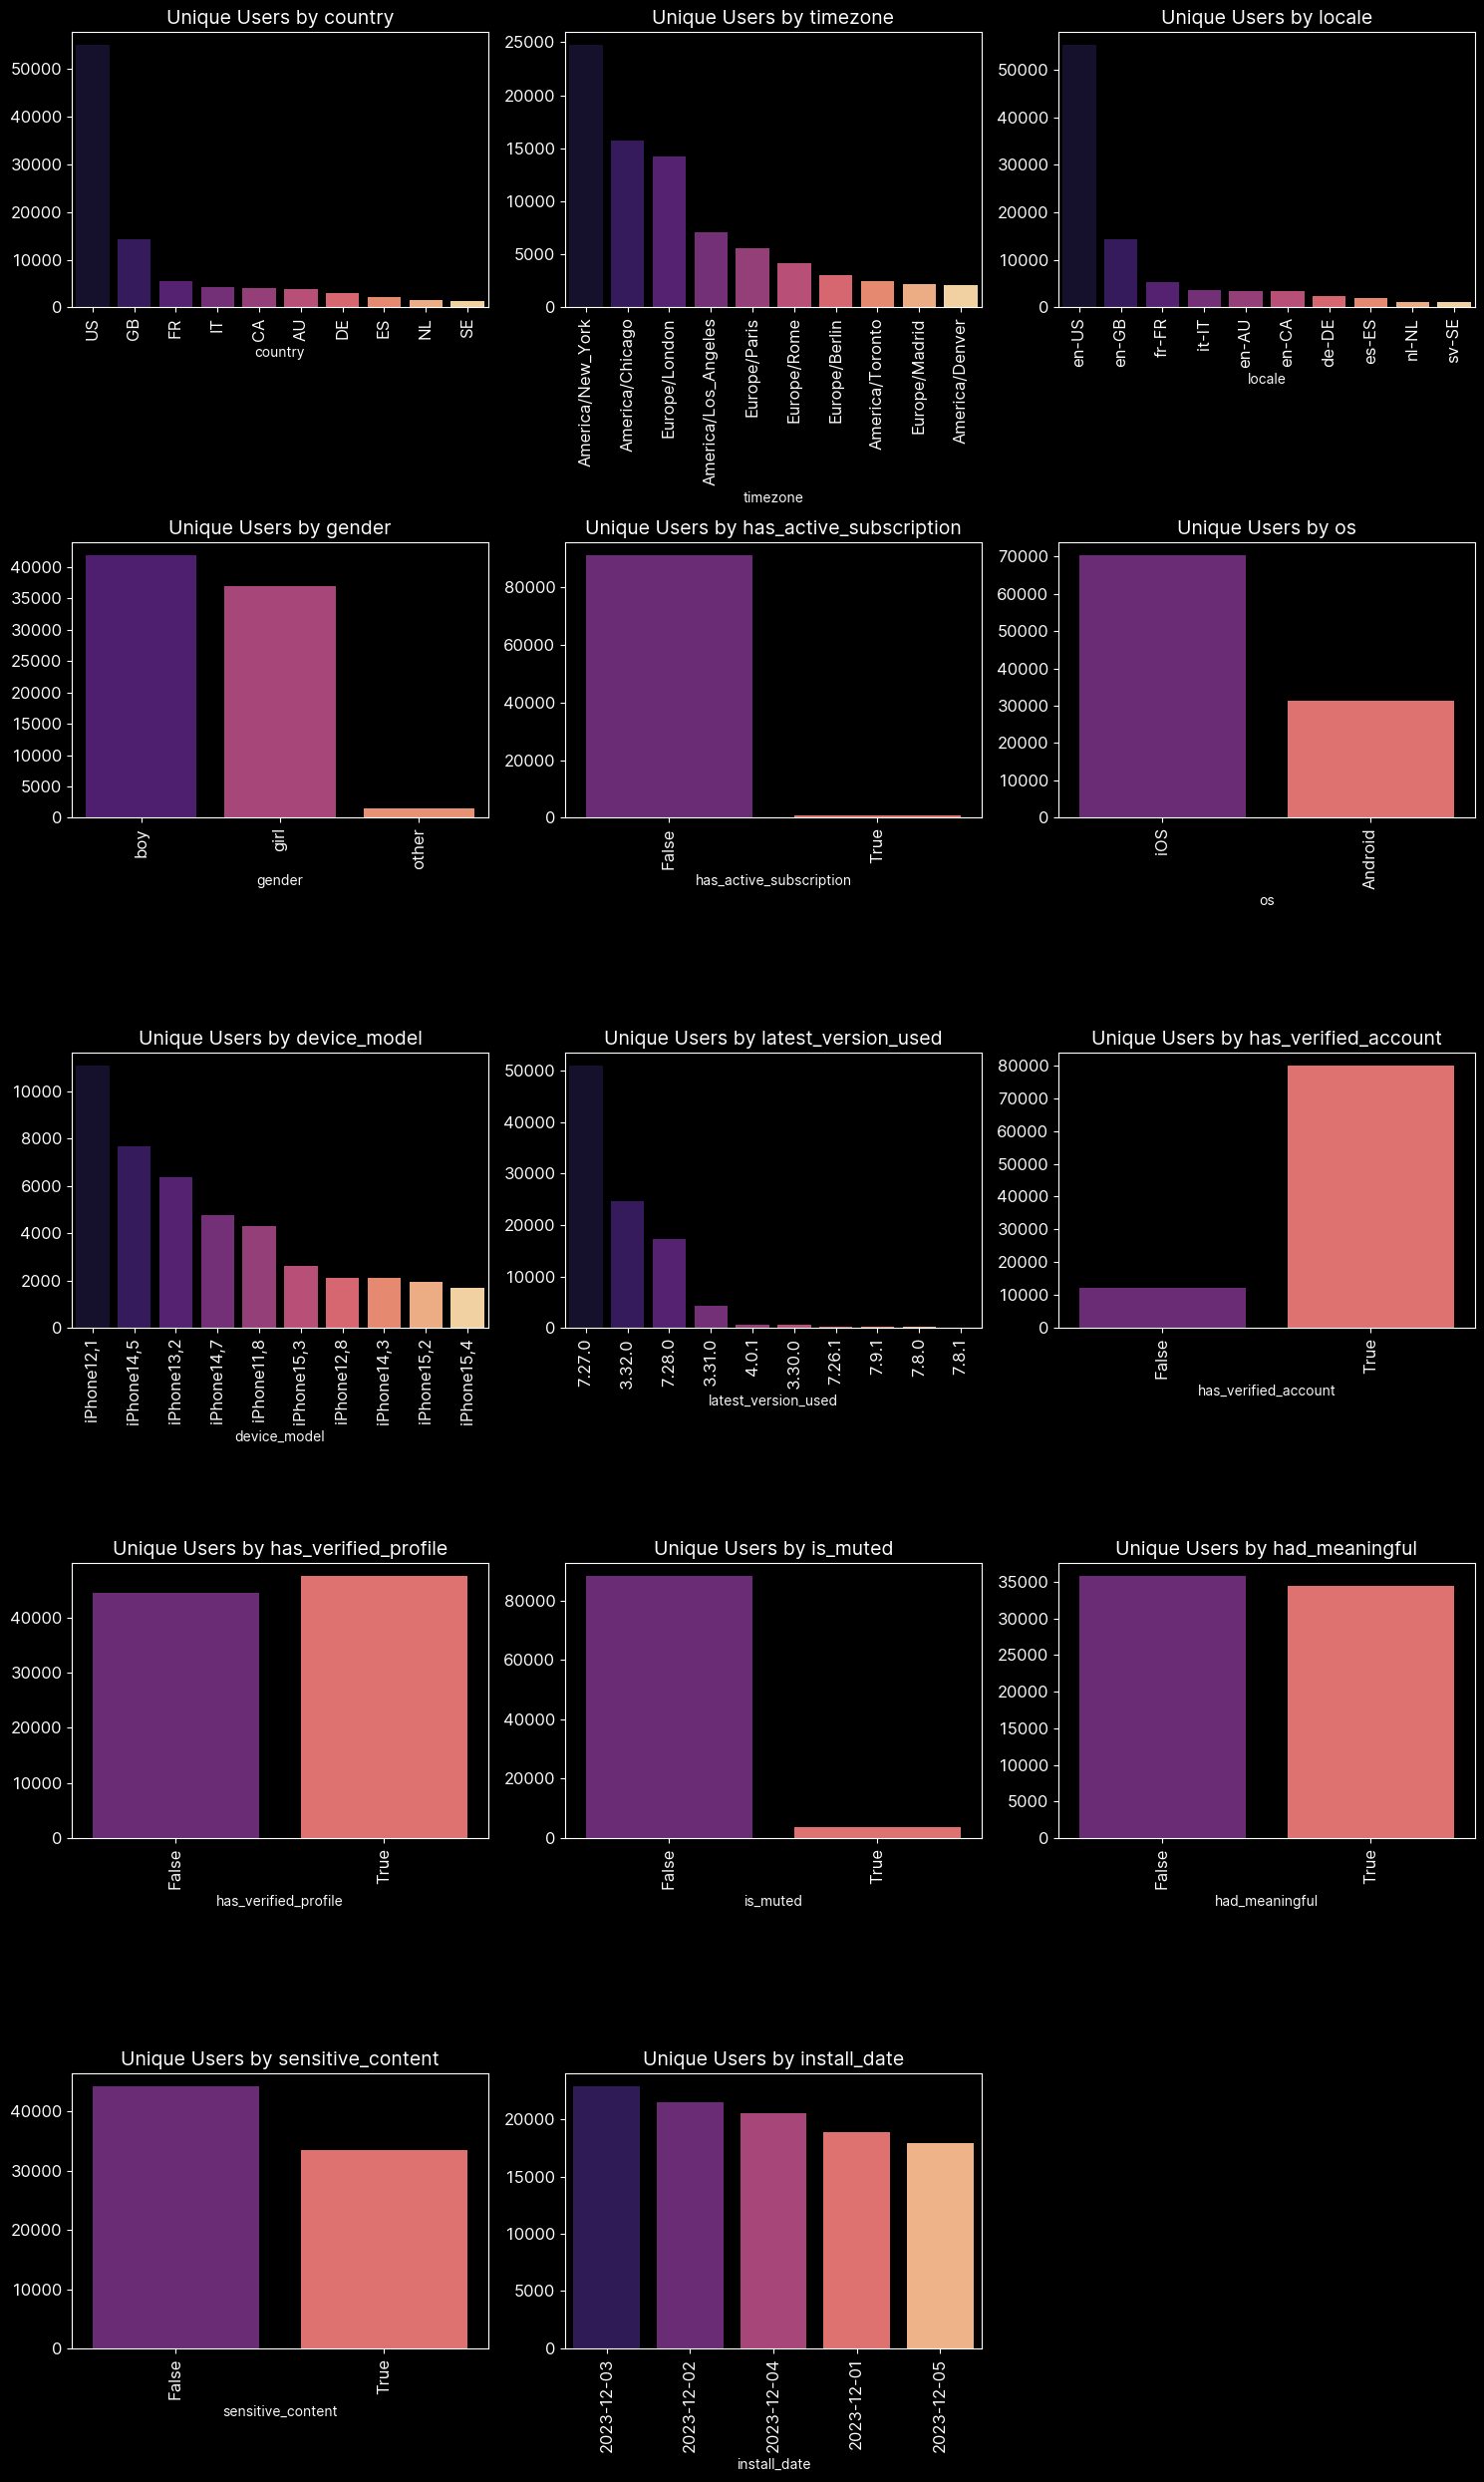

In [23]:
column_order = ['keychain_udid', 'country', 'timezone', 'locale',
                'gender', 'age', 'has_active_subscription', 'os',
                'device_model', 'latest_version_used', 'has_verified_account',
                'has_verified_profile', 'is_muted', 'session_length',
                'had_meaningful', 'sensitive_content', 'install_at',
                'install_date', 'd0', 'd3', 'd7', 'd14', 'd30']
cleaned_merged_df = cleaned_merged_df[column_order]

cleaned_merged_df['had_meaningful'] = cleaned_merged_df['had_meaningful'].map({1.0: True, 0.0: False})
cleaned_merged_df['sensitive_content'] = cleaned_merged_df['sensitive_content'].map({1.0: True, 0.0: False})

categorical_columns = cleaned_merged_df.select_dtypes(include=['object', 'bool']).columns
categorical_columns = [col for col in categorical_columns if col not in ['keychain_udid', 'install_at']]

num_cols = 3
num_rows = (len(categorical_columns) // num_cols) + (1 if len(categorical_columns) % num_cols != 0 else 0)

plt.figure(figsize=(15, num_rows * 5))
for idx, col in enumerate(categorical_columns, 1):
    unique_counts = cleaned_merged_df.groupby(col)['keychain_udid'].nunique().sort_values(ascending=False).head(10)
    plt.subplot(num_rows, num_cols, idx)
    sns.barplot(x=unique_counts.index, y=unique_counts.values, palette='magma')
    plt.title(f'Unique Users by {col}', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Numerical Columns Distribution:

gender - Min: 0, Max: 3, Mean: 1.0223974639179318

age - Min: 13.0, Max: 100.0, Mean: 17.085521077068197

session_length - Min: 0.0, Max: 51273.605999946594, Mean: 2136.1148992468898

d3 - Min: 0, Max: 1, Mean: 0.35029633567645263

d7 - Min: 0, Max: 1, Mean: 0.26119873195896587

d14 - Min: 0, Max: 1, Mean: 0.19594581290487723

d30 - Min: 0, Max: 1, Mean: 0.1416110421958375


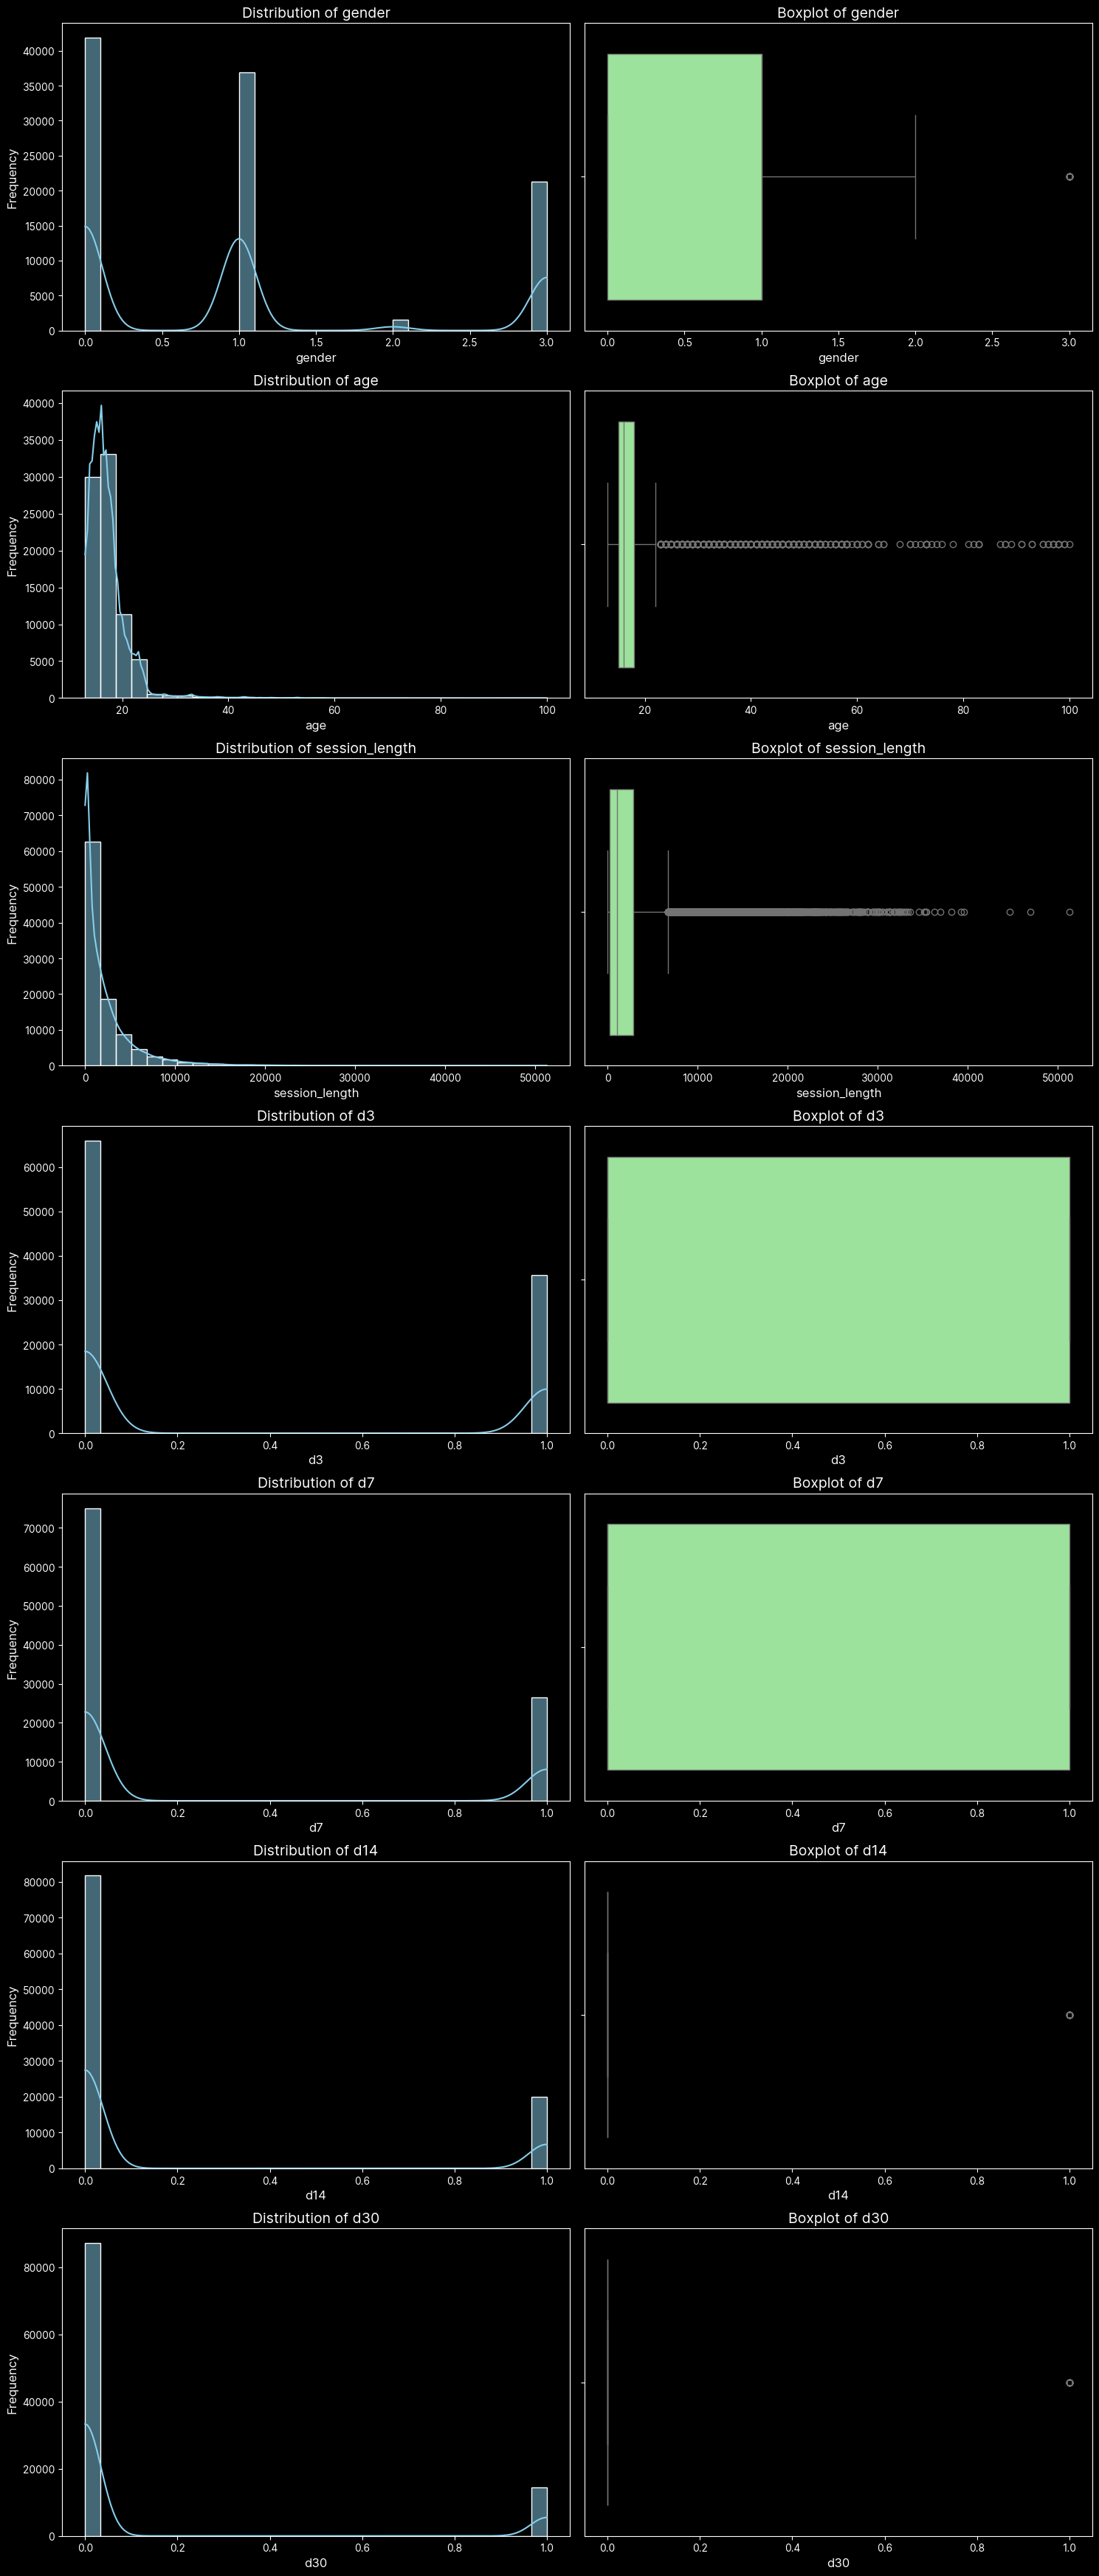

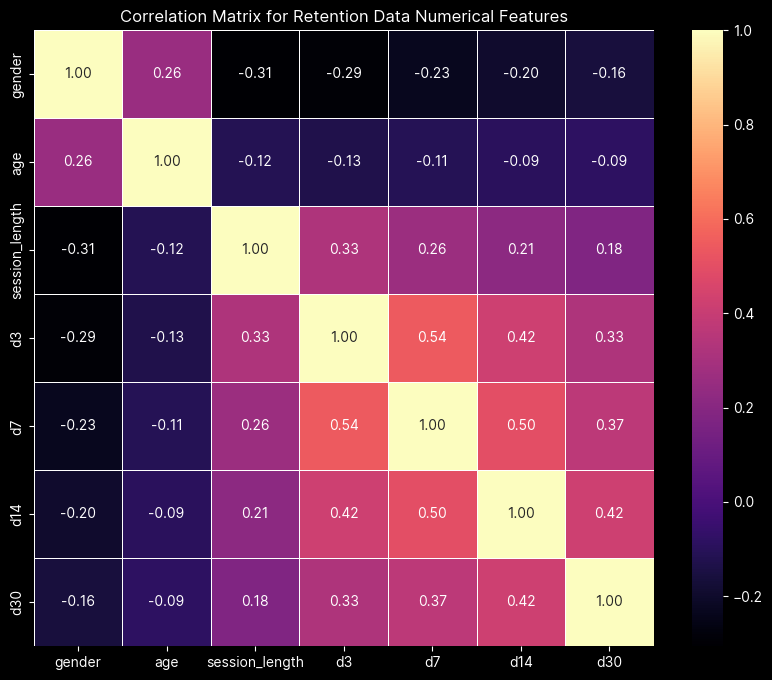


Unique Values in Columns:
keychain_udid              101571
country                       140
timezone                      229
locale                        556
gender                          4
age                            75
has_active_subscription         2
os                              2
device_model                 2588
latest_version_used           142
has_verified_account            2
has_verified_profile            2
is_muted                        2
session_length             100091
had_meaningful                  2
sensitive_content               2
install_at                 101552
install_date                    5
d0                              1
d3                              2
d7                              2
d14                             2
d30                             2
dtype: int64

Specific Columns Value Counts:
has_verified_profile
True     47534
False    44419
Name: count, dtype: int64
has_active_subscription
False    90986
True       967
Name: count, dt

In [118]:
# Encode gender as numerical
encoder = LabelEncoder()
cleaned_merged_df['gender'] = encoder.fit_transform(cleaned_merged_df['gender'])
zero_variance_cols = cleaned_merged_df.loc[:, cleaned_merged_df.nunique() <= 1].columns
numerical_columns = [col for col in cleaned_merged_df.select_dtypes(include=[np.number]).columns if col not in zero_variance_cols]
print("\nNumerical Columns Distribution:")
for col in numerical_columns:
    print(f"\n{col} - Min: {cleaned_merged_df[col].min()}, Max: {cleaned_merged_df[col].max()}, Mean: {cleaned_merged_df[col].mean()}")

plt.figure(figsize=(15, len(numerical_columns) * 5))

for idx, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 2, idx * 2 + 1)
    sns.histplot(cleaned_merged_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(len(numerical_columns), 2, idx * 2 + 2)
    sns.boxplot(data=cleaned_merged_df, x=col, color='lightgreen', orient='h')
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()
plt.show()

correlation_matrix = cleaned_merged_df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Retention Data Numerical Features')
plt.show()

unique_values = cleaned_merged_df.nunique()
print("\nUnique Values in Columns:")
print(unique_values)
print("\nSpecific Columns Value Counts:")
print(cleaned_merged_df['has_verified_profile'].value_counts())
print(cleaned_merged_df['has_active_subscription'].value_counts())

Retention is defined by day number after day 0.

$$
\text{Retention Rate (D}_N\text{)} =
\frac{\text{Number of unique users retained on day } D_N}{\text{Number of unique users who installed the app on day 0 (D}_0\text{)}}
\times 100
$$



In [25]:
cursor = conn.cursor()
query = """
WITH unique_d0_users AS (
    SELECT DISTINCT
        keychain_udid
        ,strftime('%Y', install_date) AS install_year
        ,strftime('%m', install_date) AS install_month
    FROM cleaned_merged
    WHERE d0 = 1  -- Keeping this even though d0 has zero variance, since its an extra data validation step
)
,d3_retained_users AS (
    SELECT DISTINCT
        m.keychain_udid
        ,strftime('%Y', m.install_date) AS install_year
        ,strftime('%m', m.install_date) AS install_month
    FROM cleaned_merged m
    WHERE m.d3 = 1
)
,d7_retained_users AS (
    SELECT DISTINCT
        m.keychain_udid
        ,strftime('%Y', m.install_date) AS install_year
        ,strftime('%m', m.install_date) AS install_month
    FROM cleaned_merged m
    WHERE m.d7 = 1
)
,d14_retained_users AS (
    SELECT DISTINCT
        m.keychain_udid
        ,strftime('%Y', m.install_date) AS install_year
        ,strftime('%m', m.install_date) AS install_month
    FROM cleaned_merged m
    WHERE m.d14 = 1
)
,d30_retained_users AS (
    SELECT DISTINCT
        m.keychain_udid
        ,strftime('%Y', m.install_date) AS install_year
        ,strftime('%m', m.install_date) AS install_month
    FROM cleaned_merged m
    WHERE m.d30 = 1
)
SELECT
    d0.install_year
    ,d0.install_month
    ,ROUND(CAST((SELECT COUNT(*) FROM d3_retained_users d3
                 WHERE d3.install_year = d0.install_year
                 AND d3.install_month = d0.install_month) AS float) * 100.0 /
     NULLIF(CAST((SELECT COUNT(*) FROM unique_d0_users u
                  WHERE u.install_year = d0.install_year
                  AND u.install_month = d0.install_month) AS float), 0), 2) AS d3_retention_rate
    ,ROUND(CAST((SELECT COUNT(*) FROM d7_retained_users d7
                 WHERE d7.install_year = d0.install_year
                 AND d7.install_month = d0.install_month) AS float) * 100.0 /
    NULLIF(CAST((SELECT COUNT(*) FROM unique_d0_users u
                  WHERE u.install_year = d0.install_year
                  AND u.install_month = d0.install_month) AS float), 0), 2) AS d7_retention_rate
    ,ROUND(CAST((SELECT COUNT(*) FROM d14_retained_users d14
                 WHERE d14.install_year = d0.install_year
                 AND d14.install_month = d0.install_month) AS float) * 100.0 /
     NULLIF(CAST((SELECT COUNT(*) FROM unique_d0_users u
                  WHERE u.install_year = d0.install_year
                  AND u.install_month = d0.install_month) AS float), 0), 2) AS d14_retention_rate
    ,ROUND(CAST((SELECT COUNT(*) FROM d30_retained_users d30
                 WHERE d30.install_year = d0.install_year
                 AND d30.install_month = d0.install_month) AS float) * 100.0 /
     NULLIF(CAST((SELECT COUNT(*) FROM unique_d0_users u
                  WHERE u.install_year = d0.install_year
                  AND u.install_month = d0.install_month) AS float), 0), 2) AS d30_retention_rate
FROM unique_d0_users d0
GROUP BY 1,2
ORDER BY 1,2
;
"""

cursor.execute(query)
rows = cursor.fetchall()
r = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(r, headers="keys", tablefmt="plain"))
cursor.close()

      install_year    install_month    d3_retention_rate    d7_retention_rate    d14_retention_rate    d30_retention_rate
 0            2023               12                35.03                26.12                  19.6                 14.16


In [26]:
def calculate_daily_retention(merged_data):
    min_date = merged_data['install_date'].min()
    max_date = merged_data['install_date'].max()

    daily_retention = []

    for install_date in pd.date_range(min_date, max_date):
        merged_data['install_date'] = pd.to_datetime(merged_data['install_date'])
        cohort = merged_data[merged_data['install_date'].dt.date == install_date.date()]

        if len(cohort) > 0:
            total_users = len(cohort)
            retention_rates = {
                'install_date': install_date.date(),
                'd3_retention': (cohort['d3'].sum() / total_users) * 100,
                'd7_retention': (cohort['d7'].sum() / total_users) * 100,
                'd14_retention': (cohort['d14'].sum() / total_users) * 100,
                'd30_retention': (cohort['d30'].sum() / total_users) * 100,
                'cohort_size': total_users
            }
            daily_retention.append(retention_rates)

    return pd.DataFrame(daily_retention)

daily_retention = calculate_daily_retention(cleaned_merged_df)

print("\nDaily Retention Analysis:")
print(daily_retention.to_string(index=False))
print("\nAverage Retention Rates:")
print(f"3-Day Retention: {daily_retention['d3_retention'].mean():.2f}%")
print(f"7-Day Retention: {daily_retention['d7_retention'].mean():.2f}%")
print(f"14-Day Retention: {daily_retention['d14_retention'].mean():.2f}%")
print(f"30-Day Retention: {daily_retention['d30_retention'].mean():.2f}%")


Daily Retention Analysis:
install_date  d3_retention  d7_retention  d14_retention  d30_retention  cohort_size
  2023-12-01     34.999735     25.446642      19.424270      13.152733        18863
  2023-12-02     34.397576     26.790958      19.958052      14.882312        21455
  2023-12-03     34.147941     26.147591      19.769170      14.147067        22874
  2023-12-04     35.848136     26.039430      19.519813      14.605700        20492
  2023-12-05     36.008944     26.081610      19.200671      13.868083        17890

Average Retention Rates:
3-Day Retention: 35.08%
7-Day Retention: 26.10%
14-Day Retention: 19.57%
30-Day Retention: 14.13%


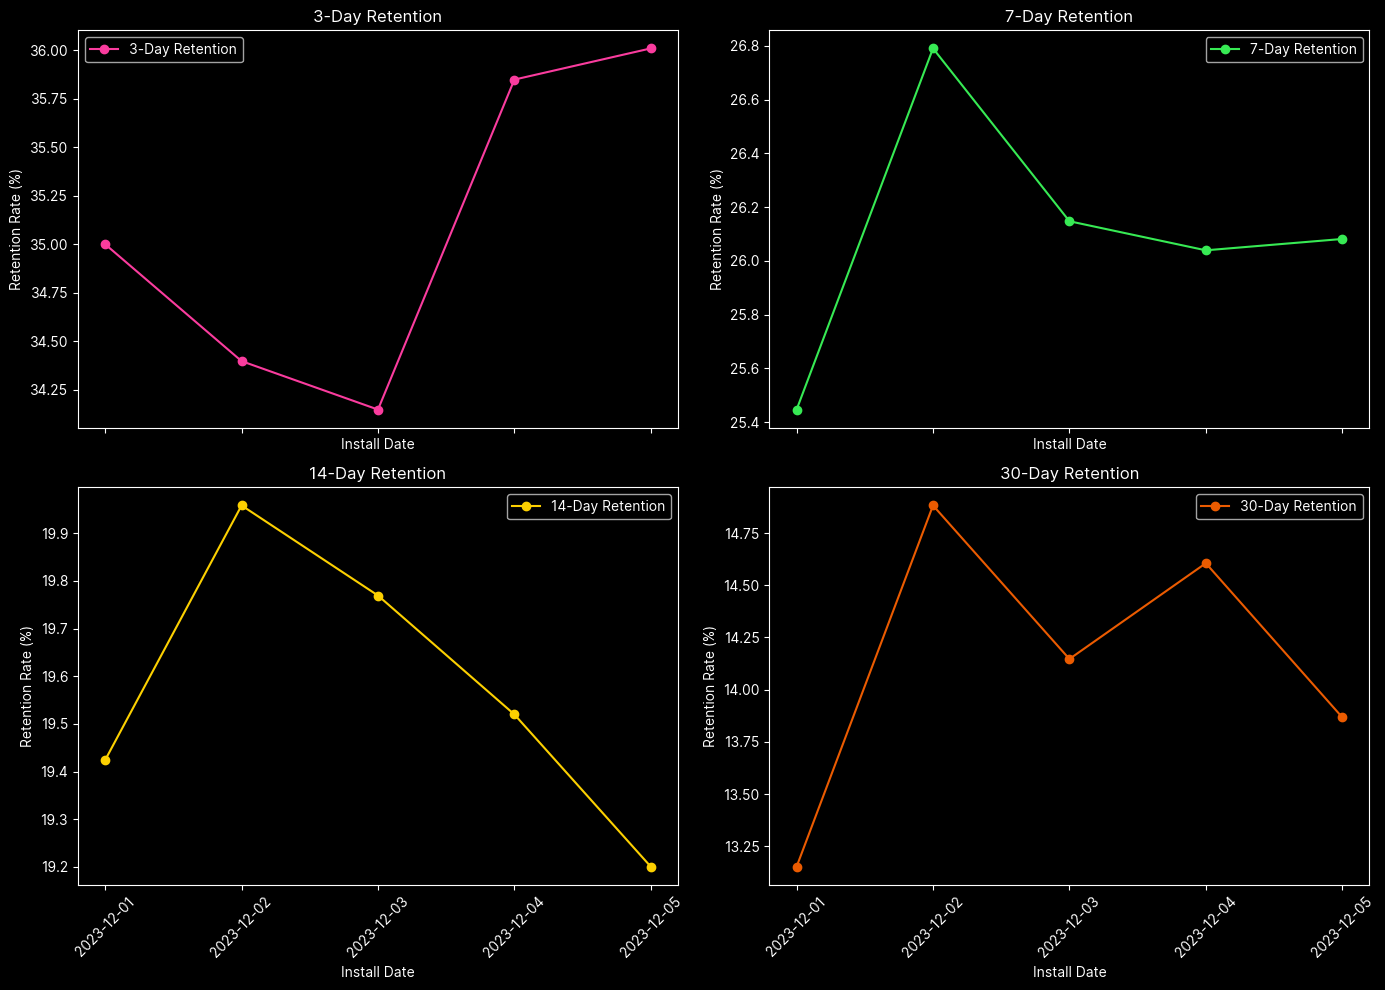

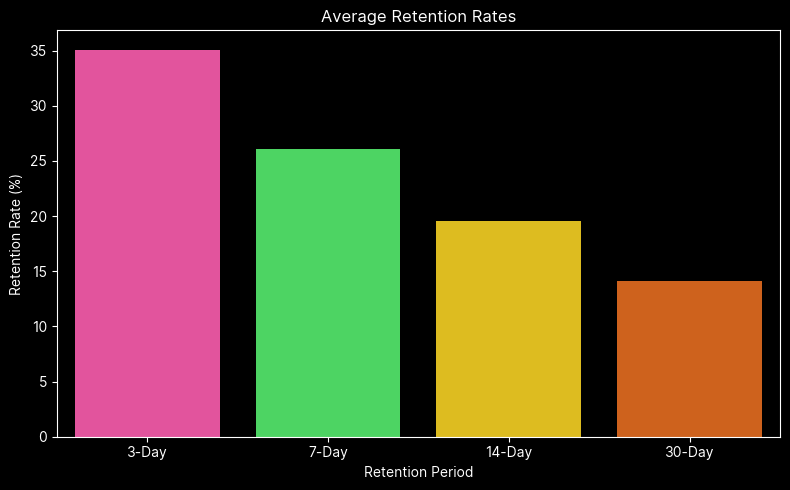

In [27]:
def plot_retention(daily_retention):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    # 3-day retention
    axes[0, 0].plot(daily_retention['install_date'], daily_retention['d3_retention'], marker='o', color=retention_colors[0], label='3-Day Retention')
    axes[0, 0].set_title('3-Day Retention', color='white')
    axes[0, 0].set_ylabel('Retention Rate (%)', color='white')
    axes[0, 0].legend()
    axes[0, 0].grid(False)

    # 7-day retention
    axes[0, 1].plot(daily_retention['install_date'], daily_retention['d7_retention'], marker='o', color=retention_colors[1], label='7-Day Retention')
    axes[0, 1].set_title('7-Day Retention', color='white')
    axes[0, 1].set_ylabel('Retention Rate (%)', color='white')
    axes[0, 1].legend()
    axes[0, 1].grid(False)

    # 14-day retention
    axes[1, 0].plot(daily_retention['install_date'], daily_retention['d14_retention'], marker='o', color=retention_colors[2], label='14-Day Retention')
    axes[1, 0].set_title('14-Day Retention', color='white')
    axes[1, 0].set_ylabel('Retention Rate (%)', color='white')
    axes[1, 0].legend()
    axes[1, 0].grid(False)

    # 30-day retention
    axes[1, 1].plot(daily_retention['install_date'], daily_retention['d30_retention'], marker='o', color=retention_colors[3], label='30-Day Retention')
    axes[1, 1].set_title('30-Day Retention', color='white')
    axes[1, 1].set_ylabel('Retention Rate (%)', color='white')
    axes[1, 1].legend()
    axes[1, 1].grid(False)

    for ax in axes.flat:
        ax.set_xlabel('Install Date', color='white')
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.tick_params(axis='x', rotation=45, labelcolor='white')

    plt.tight_layout()
    plt.savefig('/content/retention_analysis.jpg', format='jpeg')
    plt.show()

plot_retention(daily_retention)

def plot_average_retention(daily_retention):
    avg_retention = [
        daily_retention['d3_retention'].mean(),
        daily_retention['d7_retention'].mean(),
        daily_retention['d14_retention'].mean(),
        daily_retention['d30_retention'].mean()
    ]
    periods = ['3-Day', '7-Day', '14-Day', '30-Day']

    plt.style.use('dark_background')
    plt.figure(figsize=(8, 5))
    sns.barplot(x=periods, y=avg_retention, palette=retention_colors)
    plt.title('Average Retention Rates', color='white')
    plt.ylabel('Retention Rate (%)', color='white')
    plt.xlabel('Retention Period', color='white')
    plt.tight_layout()
    plt.savefig('/content/average_retention.jpg', format='jpeg')
    plt.show()

plot_average_retention(daily_retention)


### Retention based on verification status

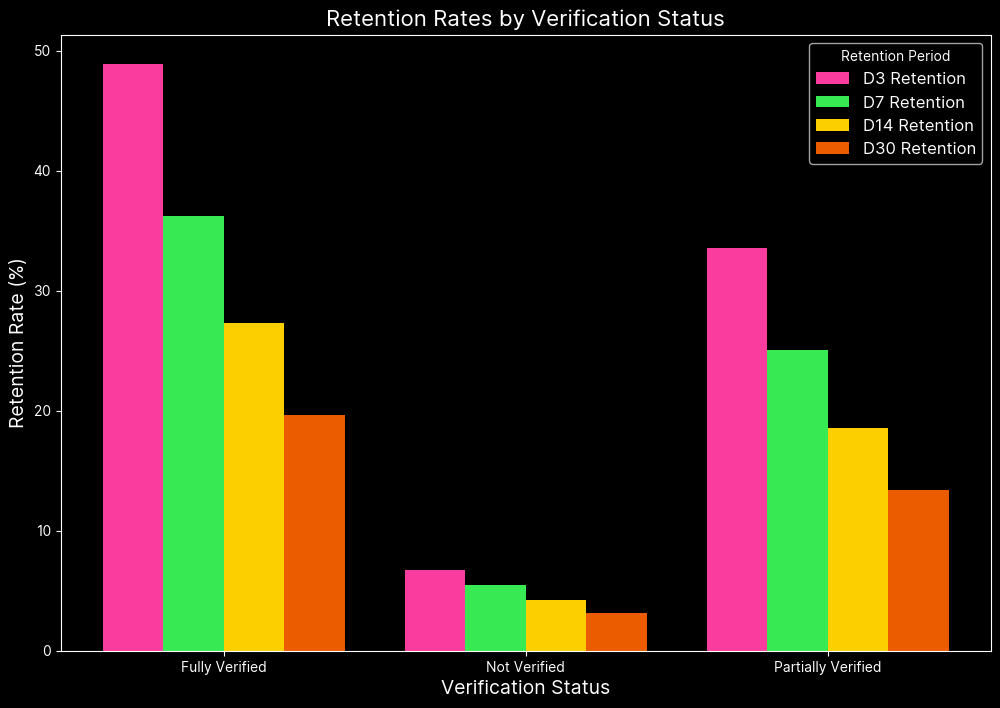

In [28]:
cursor = conn.cursor()

query = """
WITH verified_users AS (
    SELECT
        keychain_udid
        ,CASE
            WHEN has_verified_account = TRUE AND has_verified_profile = TRUE THEN 'Fully Verified'
            WHEN has_verified_account = TRUE OR has_verified_profile = TRUE THEN 'Partially Verified'
            ELSE 'Not Verified'
        END AS verification_status
    FROM cleaned_merged
)
,retained_users AS (
    SELECT
        r.keychain_udid
        ,r.d3
        ,r.d7
        ,r.d14
        ,r.d30
        ,vu.verification_status
    FROM retention r
    JOIN verified_users vu
    ON r.keychain_udid = vu.keychain_udid
)
SELECT
    verification_status
    ,AVG(CASE WHEN d3 = TRUE THEN 1 ELSE 0 END) * 100 AS d3_retention_rate
    ,AVG(CASE WHEN d7 = TRUE THEN 1 ELSE 0 END) * 100 AS d7_retention_rate
    ,AVG(CASE WHEN d14 = TRUE THEN 1 ELSE 0 END) * 100 AS d14_retention_rate
    ,AVG(CASE WHEN d30 = TRUE THEN 1 ELSE 0 END) * 100 AS d30_retention_rate
FROM retained_users
GROUP BY 1
ORDER BY 1
;
"""

cursor.execute(query)

columns = [desc[0] for desc in cursor.description]
results = cursor.fetchall()
df = pd.DataFrame(results, columns=columns)
cursor.close()

plt.figure(figsize=(12, 8))
x_labels = df['verification_status'].unique()
bar_width = 0.2
index = np.arange(len(x_labels))
bar1 = plt.bar(index - 1.5*bar_width, df.groupby('verification_status')['d3_retention_rate'].mean(), bar_width, label='D3 Retention', color=retention_colors[0])
bar2 = plt.bar(index - 0.5*bar_width, df.groupby('verification_status')['d7_retention_rate'].mean(), bar_width, label='D7 Retention', color=retention_colors[1])
bar3 = plt.bar(index + 0.5*bar_width, df.groupby('verification_status')['d14_retention_rate'].mean(), bar_width, label='D14 Retention', color=retention_colors[2])
bar4 = plt.bar(index + 1.5*bar_width, df.groupby('verification_status')['d30_retention_rate'].mean(), bar_width, label='D30 Retention', color=retention_colors[3])

plt.xlabel('Verification Status', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.title('Retention Rates by Verification Status', fontsize=16)
plt.xticks(index, x_labels, rotation=0)
plt.legend(title='Retention Period', fontsize=12)
plt.savefig('/content/retention_by_verification.jpg', format='jpeg')
plt.show()

In [124]:
cursor = conn.cursor()

query = """
WITH user_cohorts AS (
    SELECT
        keychain_udid
        ,has_verified_account
        ,has_verified_profile
        ,has_active_subscription
        ,had_meaningful
        ,session_length
        ,d0,d3,d7,d14,d30
    FROM cleaned_merged
)
,retention_rates AS (
    SELECT
        has_verified_account
        ,has_verified_profile
        ,has_active_subscription
        ,had_meaningful
        ,CAST(AVG(session_length) as INT) AS avg_session_length
        ,COUNT(DISTINCT CASE WHEN d0 = TRUE THEN keychain_udid END) AS cohort_size
        ,SUM(CASE WHEN d3 = TRUE THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT CASE WHEN d0 = TRUE THEN keychain_udid END) AS d3_retention_rate
        ,SUM(CASE WHEN d7 = TRUE THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT CASE WHEN d0 = TRUE THEN keychain_udid END) AS d7_retention_rate
        ,SUM(CASE WHEN d14 = TRUE THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT CASE WHEN d0 = TRUE THEN keychain_udid END) AS d14_retention_rate
        ,SUM(CASE WHEN d30 = TRUE THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT CASE WHEN d0 = TRUE THEN keychain_udid END) AS d30_retention_rate
    FROM user_cohorts
    GROUP BY 1,2,3,4
    ORDER BY 1 desc,2 desc,3 desc, 4 desc
)
SELECT * FROM retention_rates
;
"""
cursor.execute(query)
rows = cursor.fetchall()
r = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
cursor.close()

melted = r.melt(
    id_vars=['has_verified_account', 'has_verified_profile', 'has_active_subscription', 'had_meaningful', 'avg_session_length'],
    value_vars=['d3_retention_rate', 'd7_retention_rate', 'd14_retention_rate', 'd30_retention_rate'],
    var_name='retention_period',
    value_name='retention_rate'
)
melted

,has_verified_account,has_verified_profile,has_active_subscription,had_meaningful,avg_session_length,retention_period,retention_rate
0,1.0,1.0,1.0,1.0,5899,d3_retention_rate,66.522678
1,1.0,1.0,1.0,0.0,2272,d3_retention_rate,55.078125
2,1.0,1.0,1.0,NaN,361,d3_retention_rate,34.042553
3,1.0,1.0,0.0,1.0,4602,d3_retention_rate,57.243598
4,1.0,1.0,0.0,0.0,1869,d3_retention_rate,41.683415
5,1.0,1.0,0.0,NaN,652,d3_retention_rate,32.455540
6,1.0,0.0,1.0,1.0,4922,d3_retention_rate,63.106796
7,1.0,0.0,1.0,0.0,1855,d3_retention_rate,41.333333
8,1.0,0.0,1.0,NaN,682,d3_retention_rate,39.130435
9,1.0,0.0,0.0,1.0,3923,d3_retention_rate,47.813255


                            OLS Regression Results                            
Dep. Variable:         retention_rate   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     43.42
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           3.38e-09
Time:                        15:58:55   Log-Likelihood:                -362.40
No. Observations:                  88   AIC:                             728.8
Df Residuals:                      86   BIC:                             733.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.8656      2

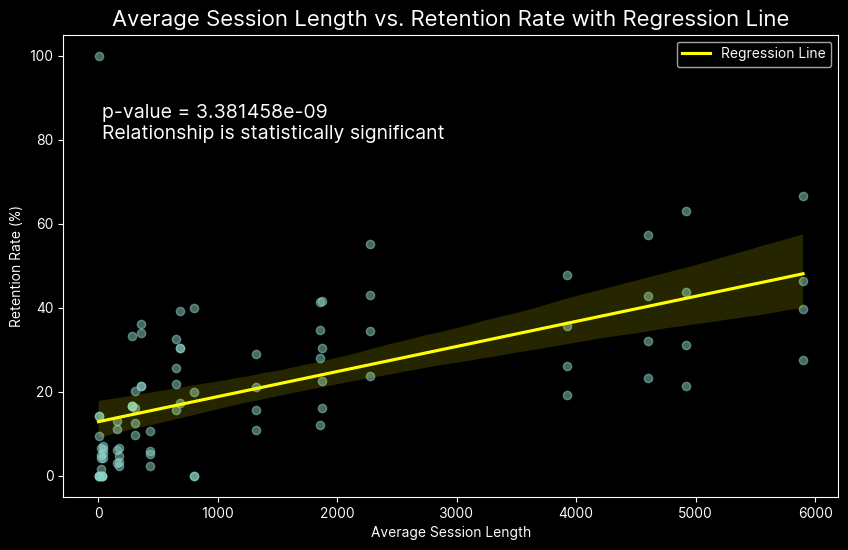

The p-value is 0.000, which is less than the significance level (0.05).
We reject the null hypothesis, since there is a statistically significant relationship between average session length and retention rate.


In [138]:
melted_cleaned = melted.dropna(subset=['avg_session_length', 'retention_rate'])
model = smf.ols('retention_rate ~ avg_session_length', data=melted_cleaned).fit()
print(model.summary())

p_value = model.pvalues['avg_session_length']
alpha = 0.05
significance_text = (f"p-value = {p_value:.6e}\n"
                     f"Relationship is {'statistically significant' if p_value < alpha else 'not statistically significant'}")

plt.figure(figsize=(10, 6))
sns.regplot(
    x='avg_session_length',
    y='retention_rate',
    data=melted_cleaned,
    line_kws={'color': 'yellow', 'label': 'Regression Line'},
    scatter_kws={'alpha': 0.5}
)

plt.annotate(
    significance_text,
    xy=(0.05, 0.85),
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=14,
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='black')
)

plt.title('Average Session Length vs. Retention Rate with Regression Line', fontsize=16)
plt.xlabel('Average Session Length')
plt.ylabel('Retention Rate (%)')
plt.legend()
plt.savefig('/content/session_retention.jpg', format='jpeg')
plt.show()

alpha = 0.05
if p_value < alpha:
    print(f"The p-value is {p_value:.3f}, which is less than the significance level ({alpha}).")
    print("We reject the null hypothesis, since there is a statistically significant relationship between average session length and retention rate.")
else:
    print(f"The p-value is {p_value:.3f}, which is greater than or equal to the significance level ({alpha}).")
    print("We do not reject the null hypothesis, since there is no statistically significant relationship between average session length and retention rate.")

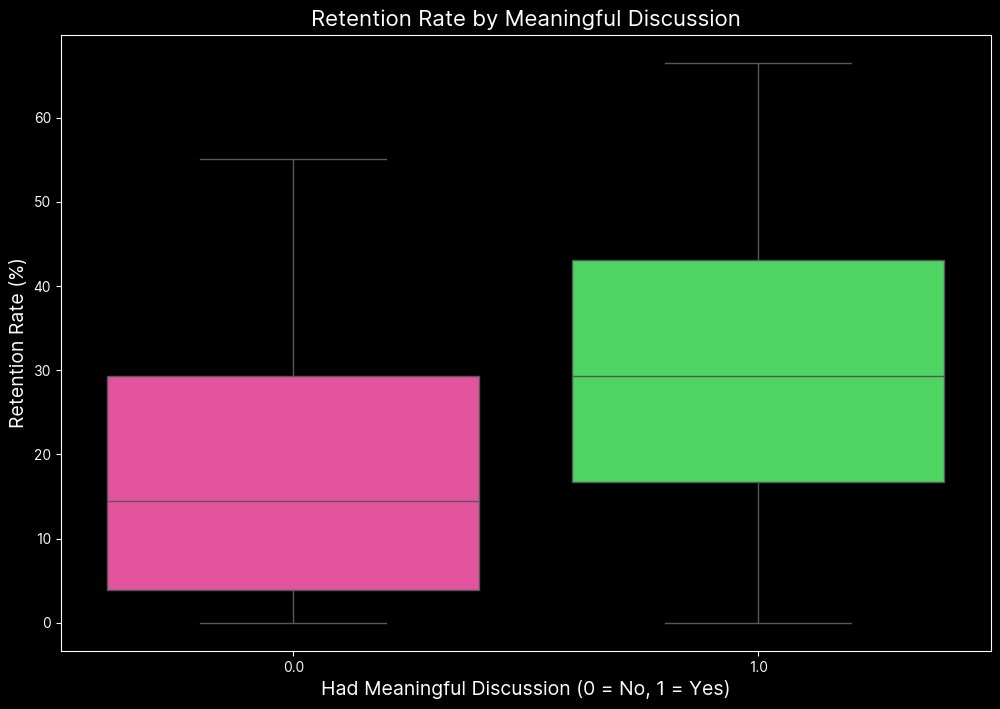

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=melted_cleaned,
    x='had_meaningful',
    y='retention_rate',
    palette=retention_colors
)

plt.title('Retention Rate by Meaningful Discussion', fontsize=16)
plt.xlabel('Had Meaningful Discussion (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.savefig('/content/meaningful_retention.jpg', format='jpeg')
plt.show()

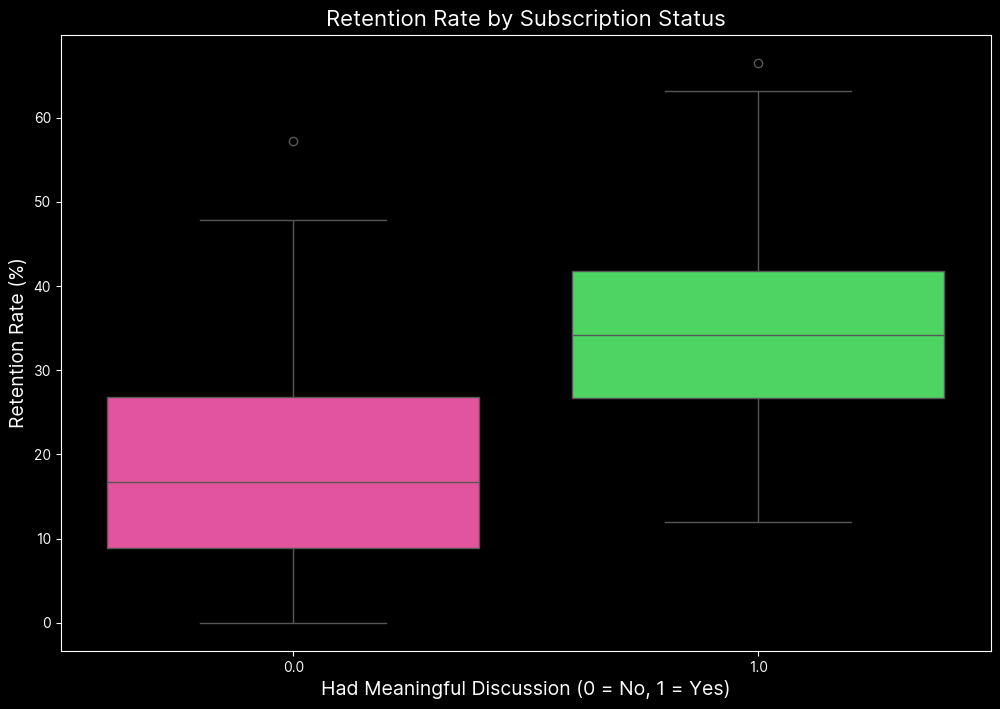

In [32]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=melted_cleaned,
    x='has_active_subscription',
    y='retention_rate',
    palette=retention_colors
)

plt.title('Retention Rate by Subscription Status', fontsize=16)
plt.xlabel('Had Meaningful Discussion (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.savefig('/content/subscription_retention.jpg', format='jpeg')
plt.show()

### Retention based on demographics



In [33]:
cursor = conn.cursor()
query = """
WITH retained_users AS (
    SELECT
        country
        ,timezone
        ,keychain_udid
        ,MAX(d0) AS d0_retained
        ,MAX(d3) AS d3_retained
        ,MAX(d7) AS d7_retained
        ,MAX(d14) AS d14_retained
        ,MAX(d30) AS d30_retained
    FROM cleaned_merged
    GROUP BY 1,2,3
)
SELECT
    country
    ,timezone
    ,COUNT(DISTINCT CASE WHEN d0_retained = 1 THEN keychain_udid END) AS total_users_d0
    ,COUNT(DISTINCT CASE WHEN d3_retained = 1 THEN keychain_udid END) AS retained_users_d3
    ,COUNT(DISTINCT CASE WHEN d7_retained = 1 THEN keychain_udid END) AS retained_users_d7
    ,COUNT(DISTINCT CASE WHEN d14_retained = 1 THEN keychain_udid END) AS retained_users_d14
    ,COUNT(DISTINCT CASE WHEN d30_retained = 1 THEN keychain_udid END) AS retained_users_d30
    -- Calculate retention rates as the ratio of retained users to total users from day 0
    ,(COUNT(DISTINCT CASE WHEN d3_retained = 1 THEN keychain_udid END) * 1.0 / COUNT(DISTINCT CASE WHEN d0_retained = 1 THEN keychain_udid END)) * 100 AS d3_retention_rate
    ,(COUNT(DISTINCT CASE WHEN d7_retained = 1 THEN keychain_udid END) * 1.0 / COUNT(DISTINCT CASE WHEN d0_retained = 1 THEN keychain_udid END)) * 100 AS d7_retention_rate
    ,(COUNT(DISTINCT CASE WHEN d14_retained = 1 THEN keychain_udid END) * 1.0 / COUNT(DISTINCT CASE WHEN d0_retained = 1 THEN keychain_udid END)) * 100 AS d14_retention_rate
    ,(COUNT(DISTINCT CASE WHEN d30_retained = 1 THEN keychain_udid END) * 1.0 / COUNT(DISTINCT CASE WHEN d0_retained = 1 THEN keychain_udid END)) * 100 AS d30_retention_rate
FROM retained_users
GROUP BY 1,2
ORDER BY total_users_d0 DESC
;
"""
cursor.execute(query)
rows = cursor.fetchall()
r = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(r.head(), headers="keys", tablefmt="plain"))
print(r.shape)
cursor.close()

    country    timezone               total_users_d0    retained_users_d3    retained_users_d7    retained_users_d14    retained_users_d30    d3_retention_rate    d7_retention_rate    d14_retention_rate    d30_retention_rate
 0  US         America/New_York                24719                 8755                 6569                  5029                  3655              35.4181              26.5747               20.3447               14.7862
 1  US         America/Chicago                 15764                 5744                 4294                  3263                  2411              36.4375              27.2393               20.6991               15.2943
 2  GB         Europe/London                   14280                 4934                 3674                  2775                  2031              34.5518              25.7283               19.4328               14.2227
 3  US         America/Los_Angeles              7047                 2485                 1792      

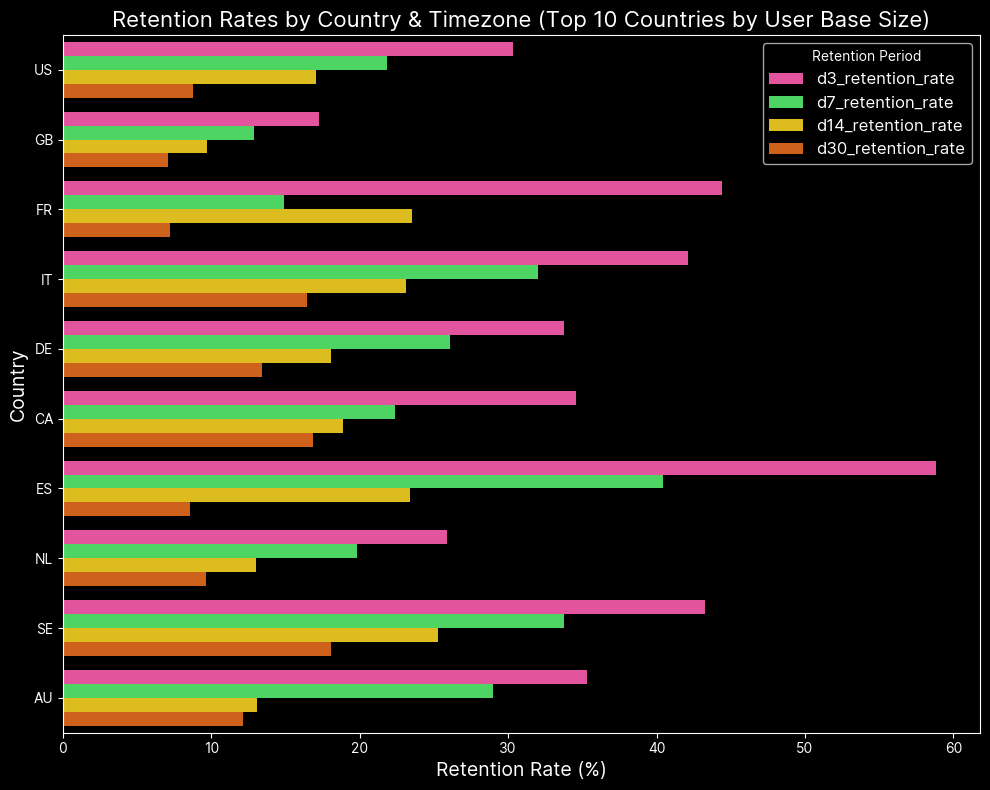

In [34]:
# Plot the top 10 countries wrt user-base size
country_user_base = r.groupby('country')['total_users_d0'].sum().reset_index()
top_10_countries = country_user_base.nlargest(10, 'total_users_d0')

r_melted = r.melt(id_vars=['country', 'timezone'],
                  value_vars=['d3_retention_rate', 'd7_retention_rate', 'd14_retention_rate', 'd30_retention_rate'],
                  var_name='retention_period',
                  value_name='retention_rate')

r_melted_filtered = r_melted[r_melted['country'].isin(top_10_countries['country'])]

plt.figure(figsize=(10, 8))
sns.barplot(x='retention_rate', y='country', hue='retention_period', data=r_melted_filtered, palette=retention_colors, ci=None)
plt.title('Retention Rates by Country & Timezone (Top 10 Countries by User Base Size)', fontsize=16)
plt.xlabel('Retention Rate (%)', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.legend(title='Retention Period', fontsize=12)
plt.tight_layout()
plt.savefig('/content/retention_by_country.jpg', format='jpeg')
plt.show()

Based on the fact that 14-day retention for FR users is higher than previous rates, data cleaning in country column still needs some work.



---



# AB Test

In [58]:
os.chdir('/content/sample_product_analysis/')
ab_data = pd.read_csv('ab_test.csv', parse_dates=['event_date'])
ab_data.tail()

,keychain_udid,event_date,ab_test_cohort,total_revenue,iap_revenue,ads_revenue,sub_revenue,meaningful_discussions,sessions
124452,secure_039FE7AB-7D00-4377-BE7A-72A50C19DD56,2023-11-21,control,0.0,0.0,0.0,0.0,0,1
124453,secure_68C1AEC8-7EB4-4D2A-A1A3-F5C5EB805FB5,2023-11-21,test,0.0,0.0,0.0,0.0,0,1
124454,secure_78C7C281-59DF-49EA-A6BD-FE8C2305CBF4,2023-11-21,test,0.0,0.0,0.0,0.0,0,4
124455,secure_F5708191-F28B-4A92-B2C2-358A6F3DBB04,2023-11-21,test,0.0,0.0,0.0,0.0,0,0
124456,secure_D123BA46-0181-419C-8646-04BA1D2CF30F,2023-11-19,test,0.0,0.0,0.0,0.0,0,6


In [139]:
overview_of_dataframes(ab_data, names=['AB Test Data'])

--- AB Test Data ---
Shape: (123540, 9)
Columns: ['keychain_udid', 'event_date', 'ab_test_cohort', 'total_revenue', 'iap_revenue', 'ads_revenue', 'sub_revenue', 'meaningful_discussions', 'sessions']
Data Types:
keychain_udid                     object
event_date                datetime64[ns]
ab_test_cohort                    object
total_revenue                    float64
iap_revenue                      float64
ads_revenue                      float64
sub_revenue                      float64
meaningful_discussions             int64
sessions                           int64
dtype: object

Summary Statistics:
+--------+---------------------------------------------+-------------------------------+------------------+-----------------+----------------+-----------------+----------------+--------------------------+-------------+
|        | keychain_udid                               | event_date                    | ab_test_cohort   |   total_revenue |    iap_revenue |     ads_revenue |    su

In [59]:
duplicate_rows = ab_data[ab_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [60]:
ab_data = ab_data.dropna().copy()

AB data is for users in novemeber 2023, while retention data pertains to users who installed the app in dec 2023 (1 month after).  Therefore, the datasets are not used together.


Numerical Columns Distribution:

total_revenue - Min: -3.458895194392883, Max: 392.3167763297216, Mean: 0.0786928264740122

iap_revenue - Min: 0.0, Max: 392.3167763297216, Mean: 0.038176251346133706

ads_revenue - Min: 0.0, Max: 2.204442392284395, Mean: 0.01698435174427818

sub_revenue - Min: 0.0, Max: 16.724068621592554, Mean: 0.023588771869920512

meaningful_discussions - Min: 0, Max: 66, Mean: 0.8534887485834548

sessions - Min: 0, Max: 2593, Mean: 30.043799579083696


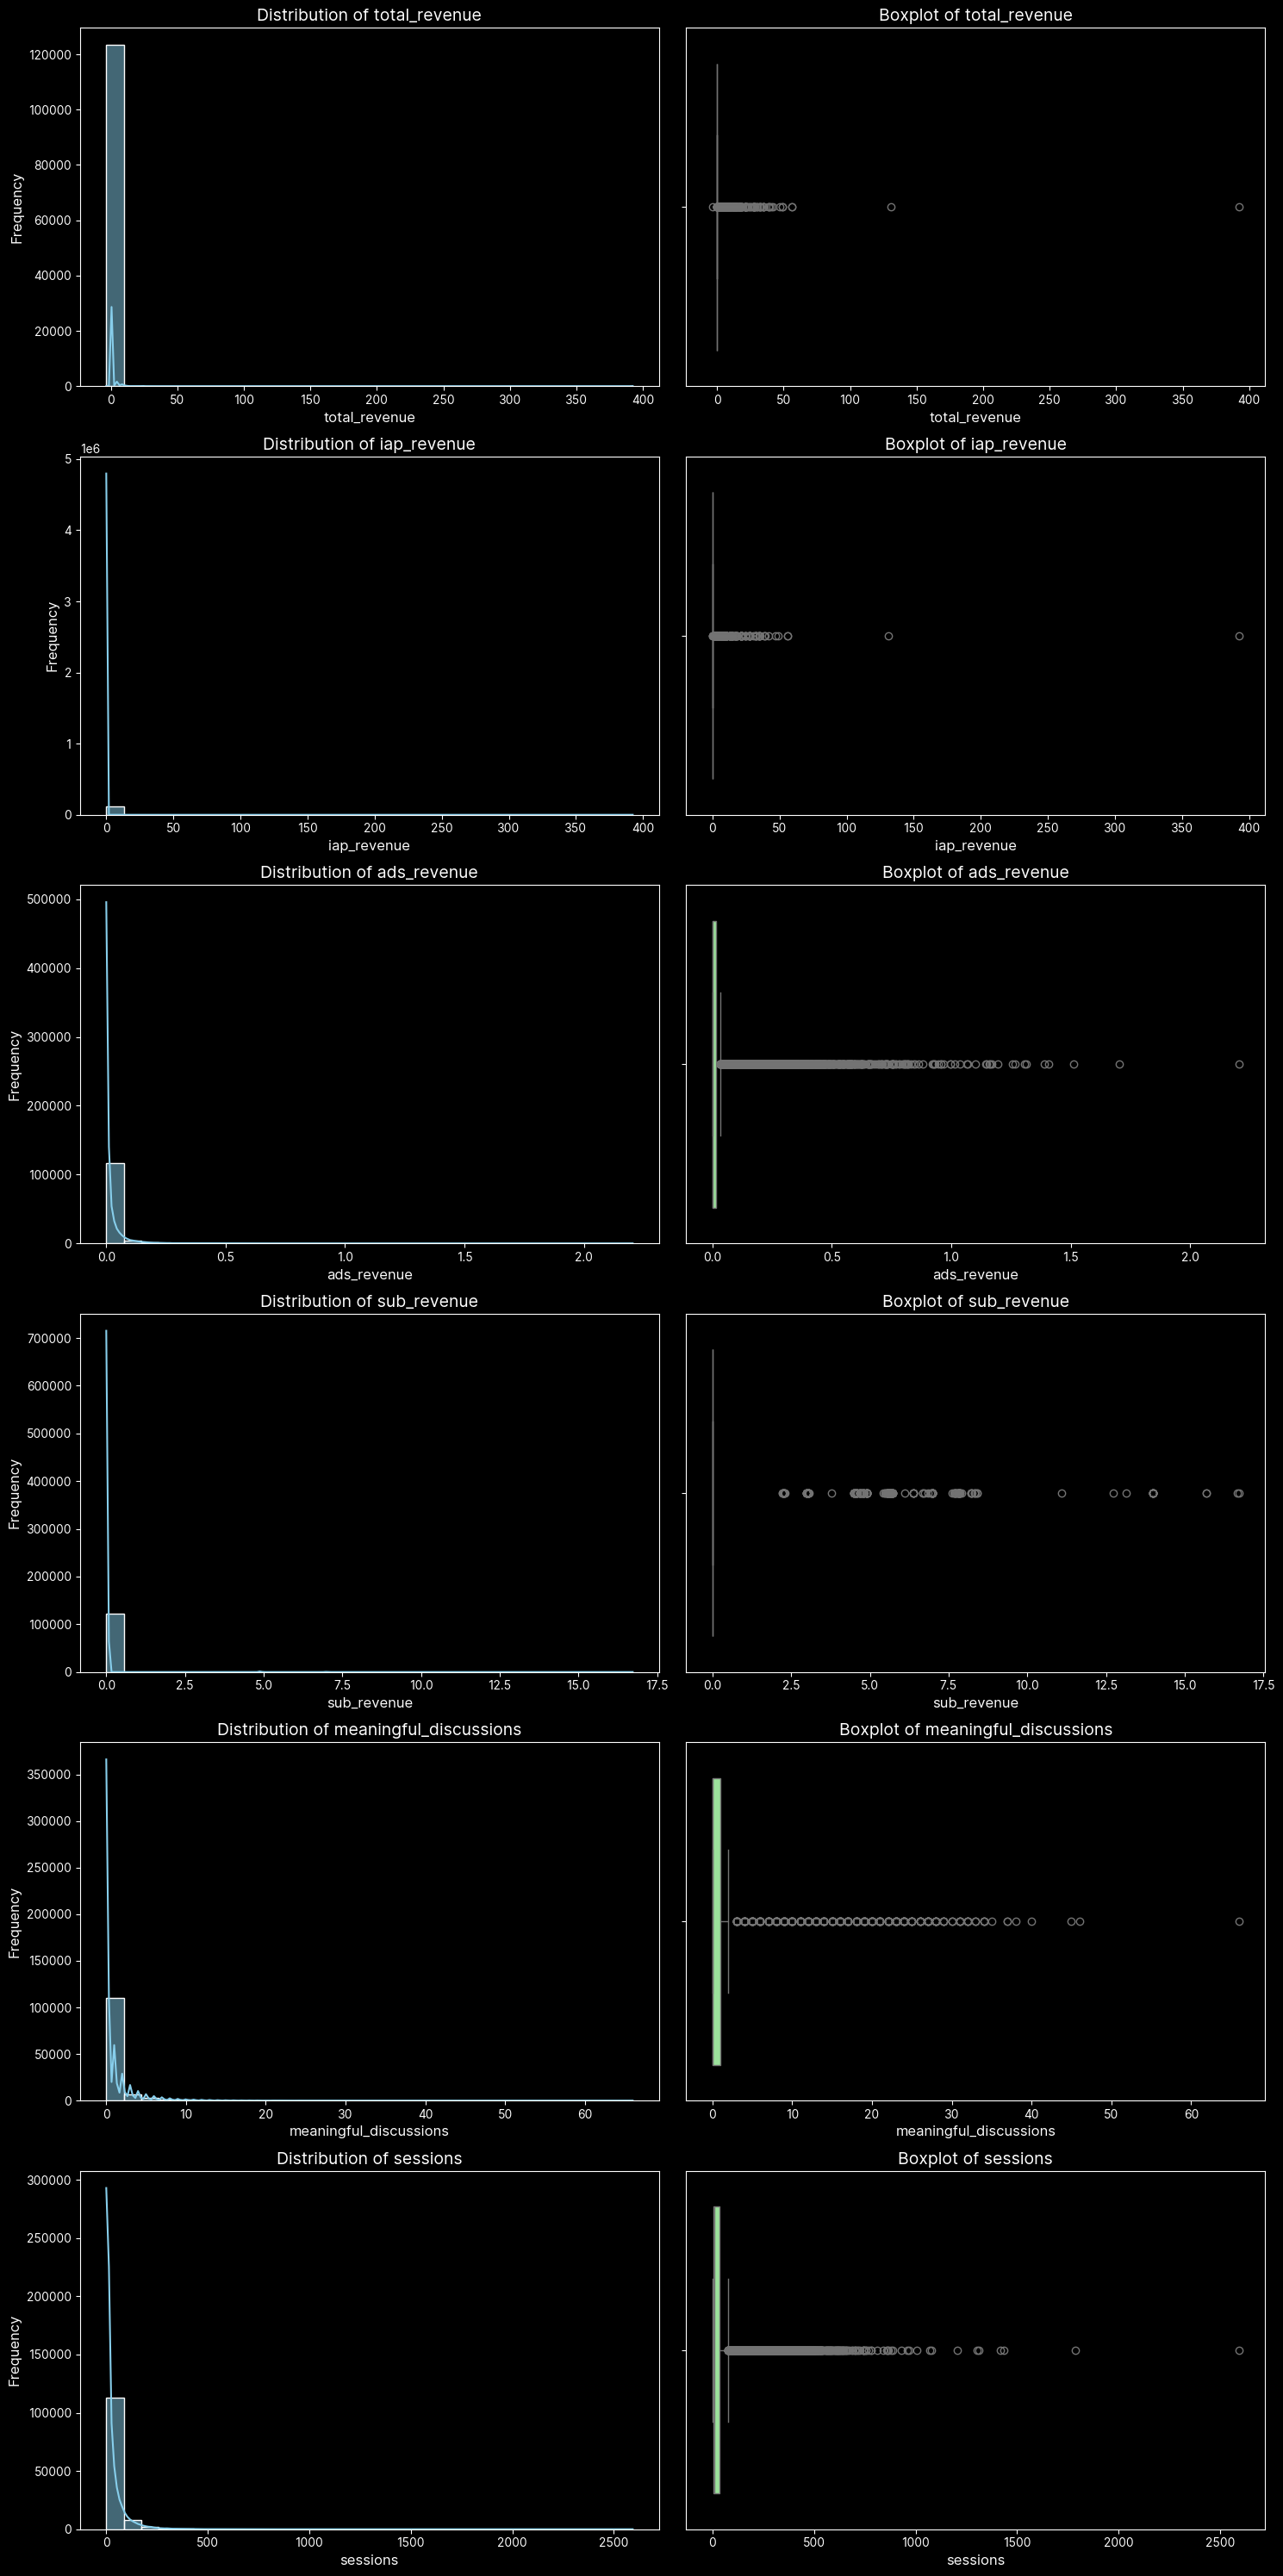

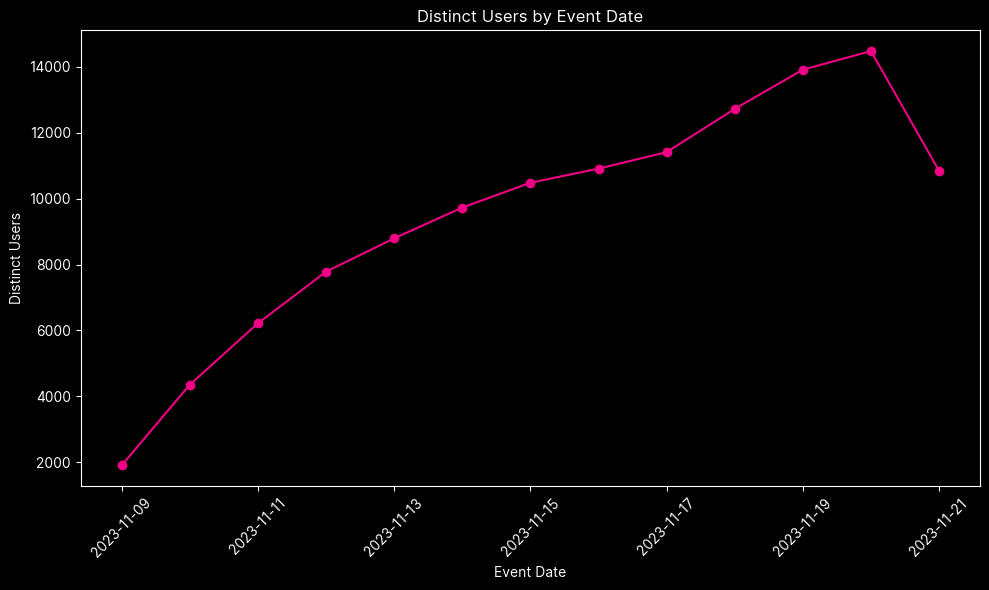

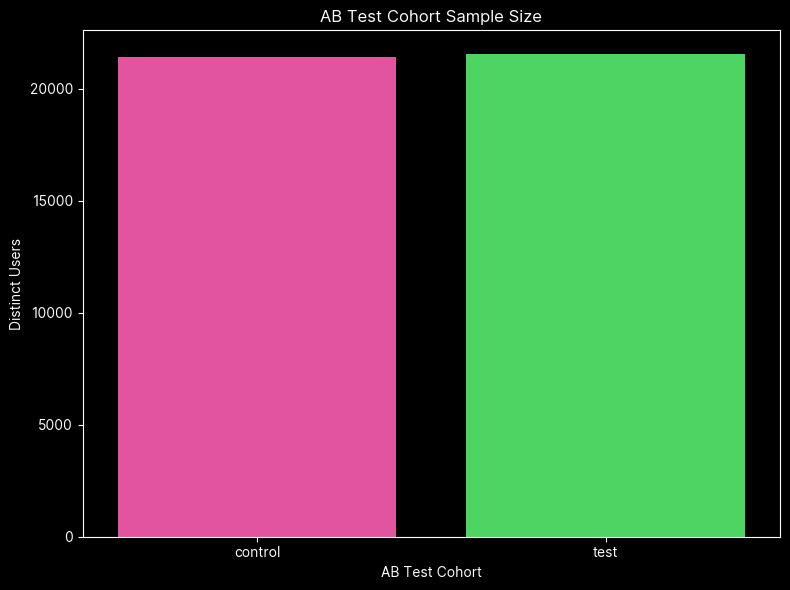

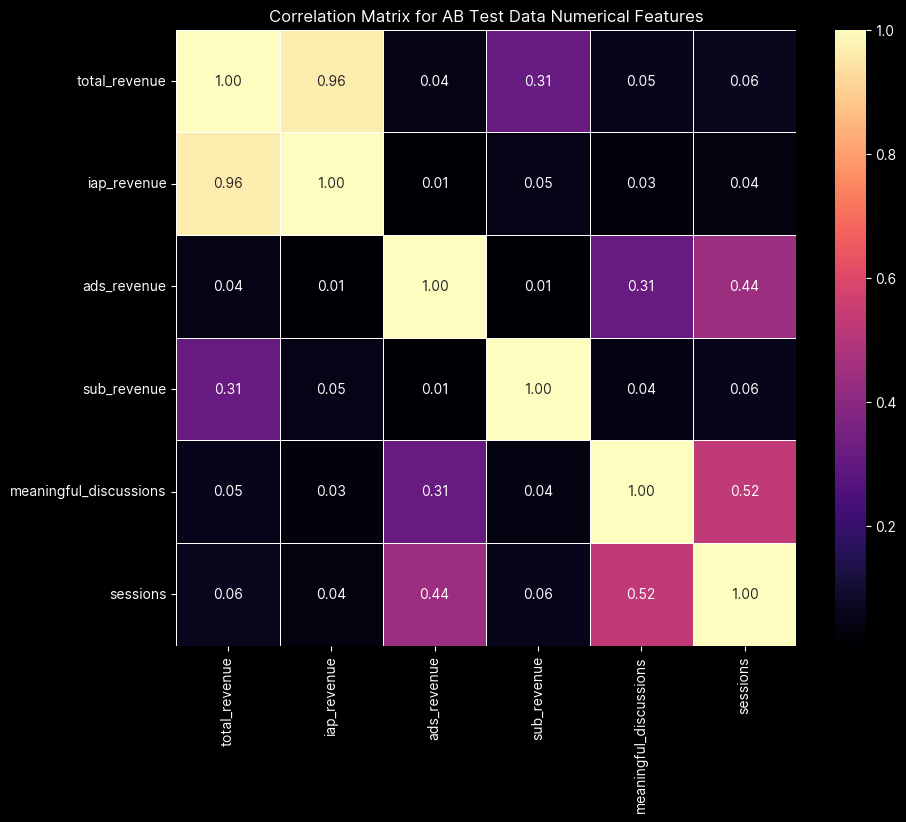


Unique Values in Columns:
keychain_udid             42966
event_date                   13
ab_test_cohort                2
total_revenue             70946
iap_revenue                 195
ads_revenue               70812
sub_revenue                 120
meaningful_discussions       42
sessions                    586
dtype: int64


In [119]:
def num_col_eda(df):
  zero_variance_cols = df.loc[:, df.nunique() <= 1].columns
  numerical_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col not in zero_variance_cols]
  print("\nNumerical Columns Distribution:")
  for col in numerical_columns:
      print(f"\n{col} - Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}")

  plt.figure(figsize=(15, len(numerical_columns) * 5))

  for idx, col in enumerate(numerical_columns):
      plt.subplot(len(numerical_columns), 2, idx * 2 + 1)
      sns.histplot(df[col], kde=True, bins=30, color='skyblue')
      plt.title(f'Distribution of {col}', fontsize=14)
      plt.xlabel(col, fontsize=12)
      plt.ylabel('Frequency', fontsize=12)

      plt.subplot(len(numerical_columns), 2, idx * 2 + 2)
      sns.boxplot(data=df, x=col, color='lightgreen', orient='h')
      plt.title(f'Boxplot of {col}', fontsize=14)
      plt.xlabel(col, fontsize=12)

  plt.tight_layout()
  plt.show()

  distinct_by_date = df.groupby('event_date')['keychain_udid'].nunique().reset_index()
  plt.figure(figsize=(10, 6))
  plt.plot(distinct_by_date['event_date'], distinct_by_date['keychain_udid'], marker='o', color='#F10086')
  plt.title('Distinct Users by Event Date')
  plt.xlabel('Event Date')
  plt.ylabel('Distinct Users')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  distinct_by_cohort = df.groupby('ab_test_cohort')['keychain_udid'].nunique().reset_index()
  plt.figure(figsize=(8, 6))
  sns.barplot(x='ab_test_cohort', y='keychain_udid', data=distinct_by_cohort, palette=retention_colors)
  plt.title('AB Test Cohort Sample Size')
  plt.xlabel('AB Test Cohort')
  plt.ylabel('Distinct Users')
  plt.tight_layout()
  plt.show()

  correlation_matrix = df[numerical_columns].corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt='.2f', linewidths=0.5)
  plt.title('Correlation Matrix for AB Test Data Numerical Features')
  plt.show()

  unique_values = df.nunique()
  print("\nUnique Values in Columns:")
  print(unique_values)

num_col_eda(ab_data)

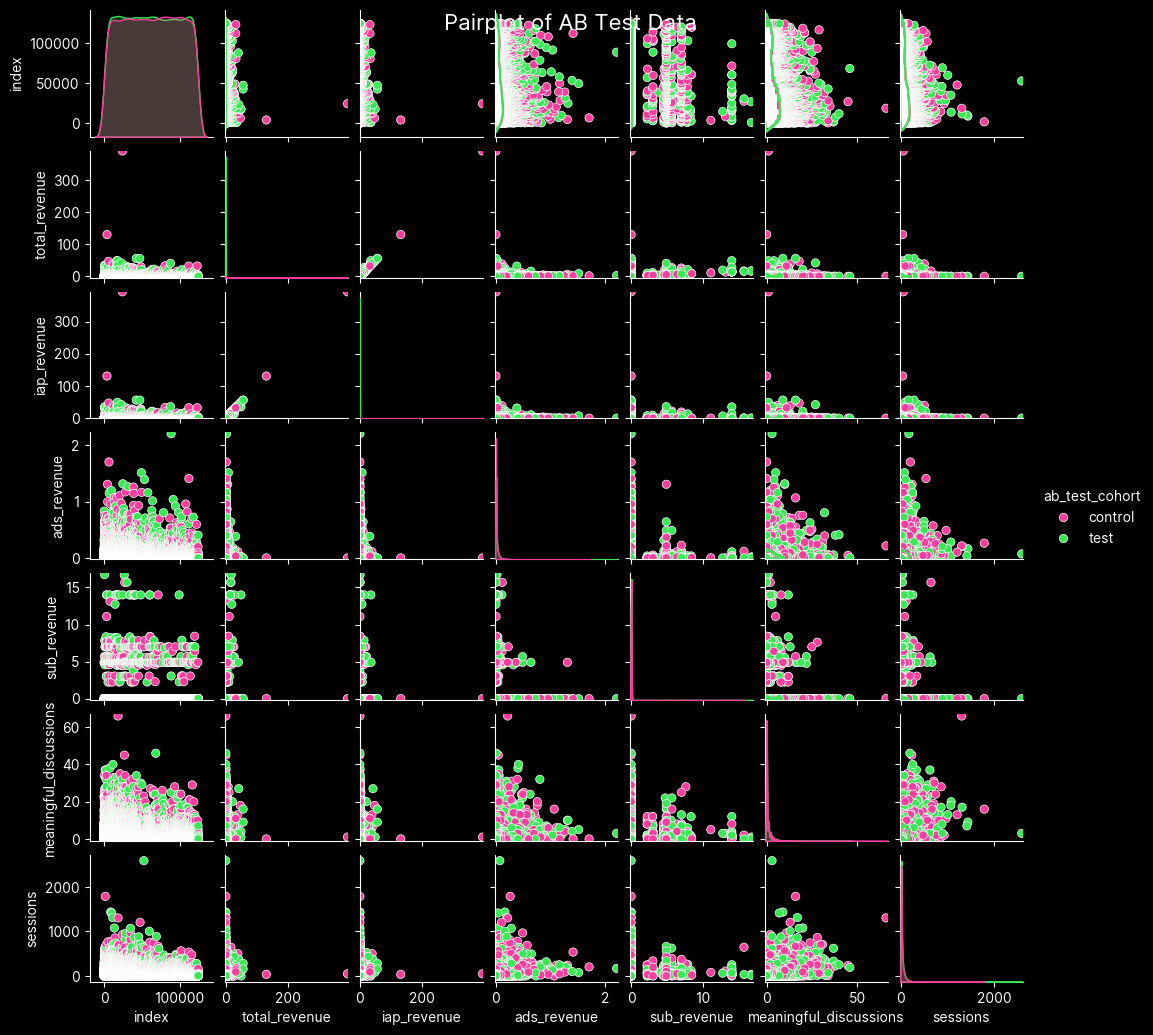

In [46]:
fig = sns.pairplot(ab_data.reset_index(), hue='ab_test_cohort', height= 1.5, corner = False, palette=retention_colors)
fig.map_upper(sns.kdeplot, levels=1)
plt.suptitle('Pairplot of AB Test Data', fontsize=16)
plt.savefig('/content/pairplot_ab.jpg', format='jpeg')
plt.show()

In [61]:
# Ensuring no intersection of users in both cohorts
user_cohorts = ab_data[['keychain_udid', 'ab_test_cohort']]
test_users = set(user_cohorts[user_cohorts['ab_test_cohort'] == 'test']['keychain_udid'])
control_users = set(user_cohorts[user_cohorts['ab_test_cohort'] == 'control']['keychain_udid'])
overlapping_users = test_users.intersection(control_users)
if overlapping_users:
    print(f"Users in both test and control groups: {len(overlapping_users)}.")
    print(overlapping_users)
else:
    print("No intersection of users wrt variants.")

Users in both test and control groups: 209.
{'secure_6B96114D-838A-43B9-8D90-D67D1FCAD2F4', 'secure_E925E127-55FC-4977-8A9C-AF576C0D66F3', 'secure_D9E456A5-0676-4CD9-8EF3-BACD4A60EBCB', 'secure_5BD35F34-5A4C-4C34-89C5-E8EC470E6941', 'secure_1F6790C9-D875-46CB-B52D-2E4435A86F8F', 'secure_C6EA6F3B-26C6-41A4-9F7B-2FBD3878C23F', 'secure_14BD8FD9-DBAD-4555-9F8D-46F6E3669D34', 'secure_C084B6CB-ABE5-4C8E-8210-16A488B12511', 'secure_09CA4BAE-7227-40C6-98EC-815D396C0397', 'secure_C8C4B4CF-715A-43AB-ADFE-D6931042EE91', 'secure_3D0C8CCD-0B5E-425F-B7E4-0703E669EDE0', 'secure_E56E3633-1878-42DA-A8A5-0361A5133C07', 'secure_8CBAB483-6E34-4F0C-A2DF-BBD4A9D68464', 'secure_B66271E2-9F08-45A7-A2B4-D621E3CCB510', 'secure_69642E41-0CE7-44BF-A302-27D0B85AB2C4', 'secure_0A58F9B8-3DCA-43CF-8BDA-B3E196B8ACB9', 'secure_7BC6EE64-E6C6-4047-B48D-9A2863379B9C', 'secure_1DAEDEE1-185A-4E3E-A201-03B7B1A09190', 'secure_EF2A6FAA-1F21-4B03-9AB6-FCB7A7EC8763', 'secure_1ABBBF70-B5ED-4AD8-9100-3D0877443844', 'secure_C3A83D2

In [62]:
# Drop the invalidated users
ab_data = ab_data[~ab_data['keychain_udid'].isin(overlapping_users)].copy()


Numerical Columns Distribution:

total_revenue - Min: -3.458895194392883, Max: 392.3167763297216, Mean: 0.0786928264740122

iap_revenue - Min: 0.0, Max: 392.3167763297216, Mean: 0.038176251346133706

ads_revenue - Min: 0.0, Max: 2.204442392284395, Mean: 0.01698435174427818

sub_revenue - Min: 0.0, Max: 16.724068621592554, Mean: 0.023588771869920512

meaningful_discussions - Min: 0, Max: 66, Mean: 0.8534887485834548

sessions - Min: 0, Max: 2593, Mean: 30.043799579083696


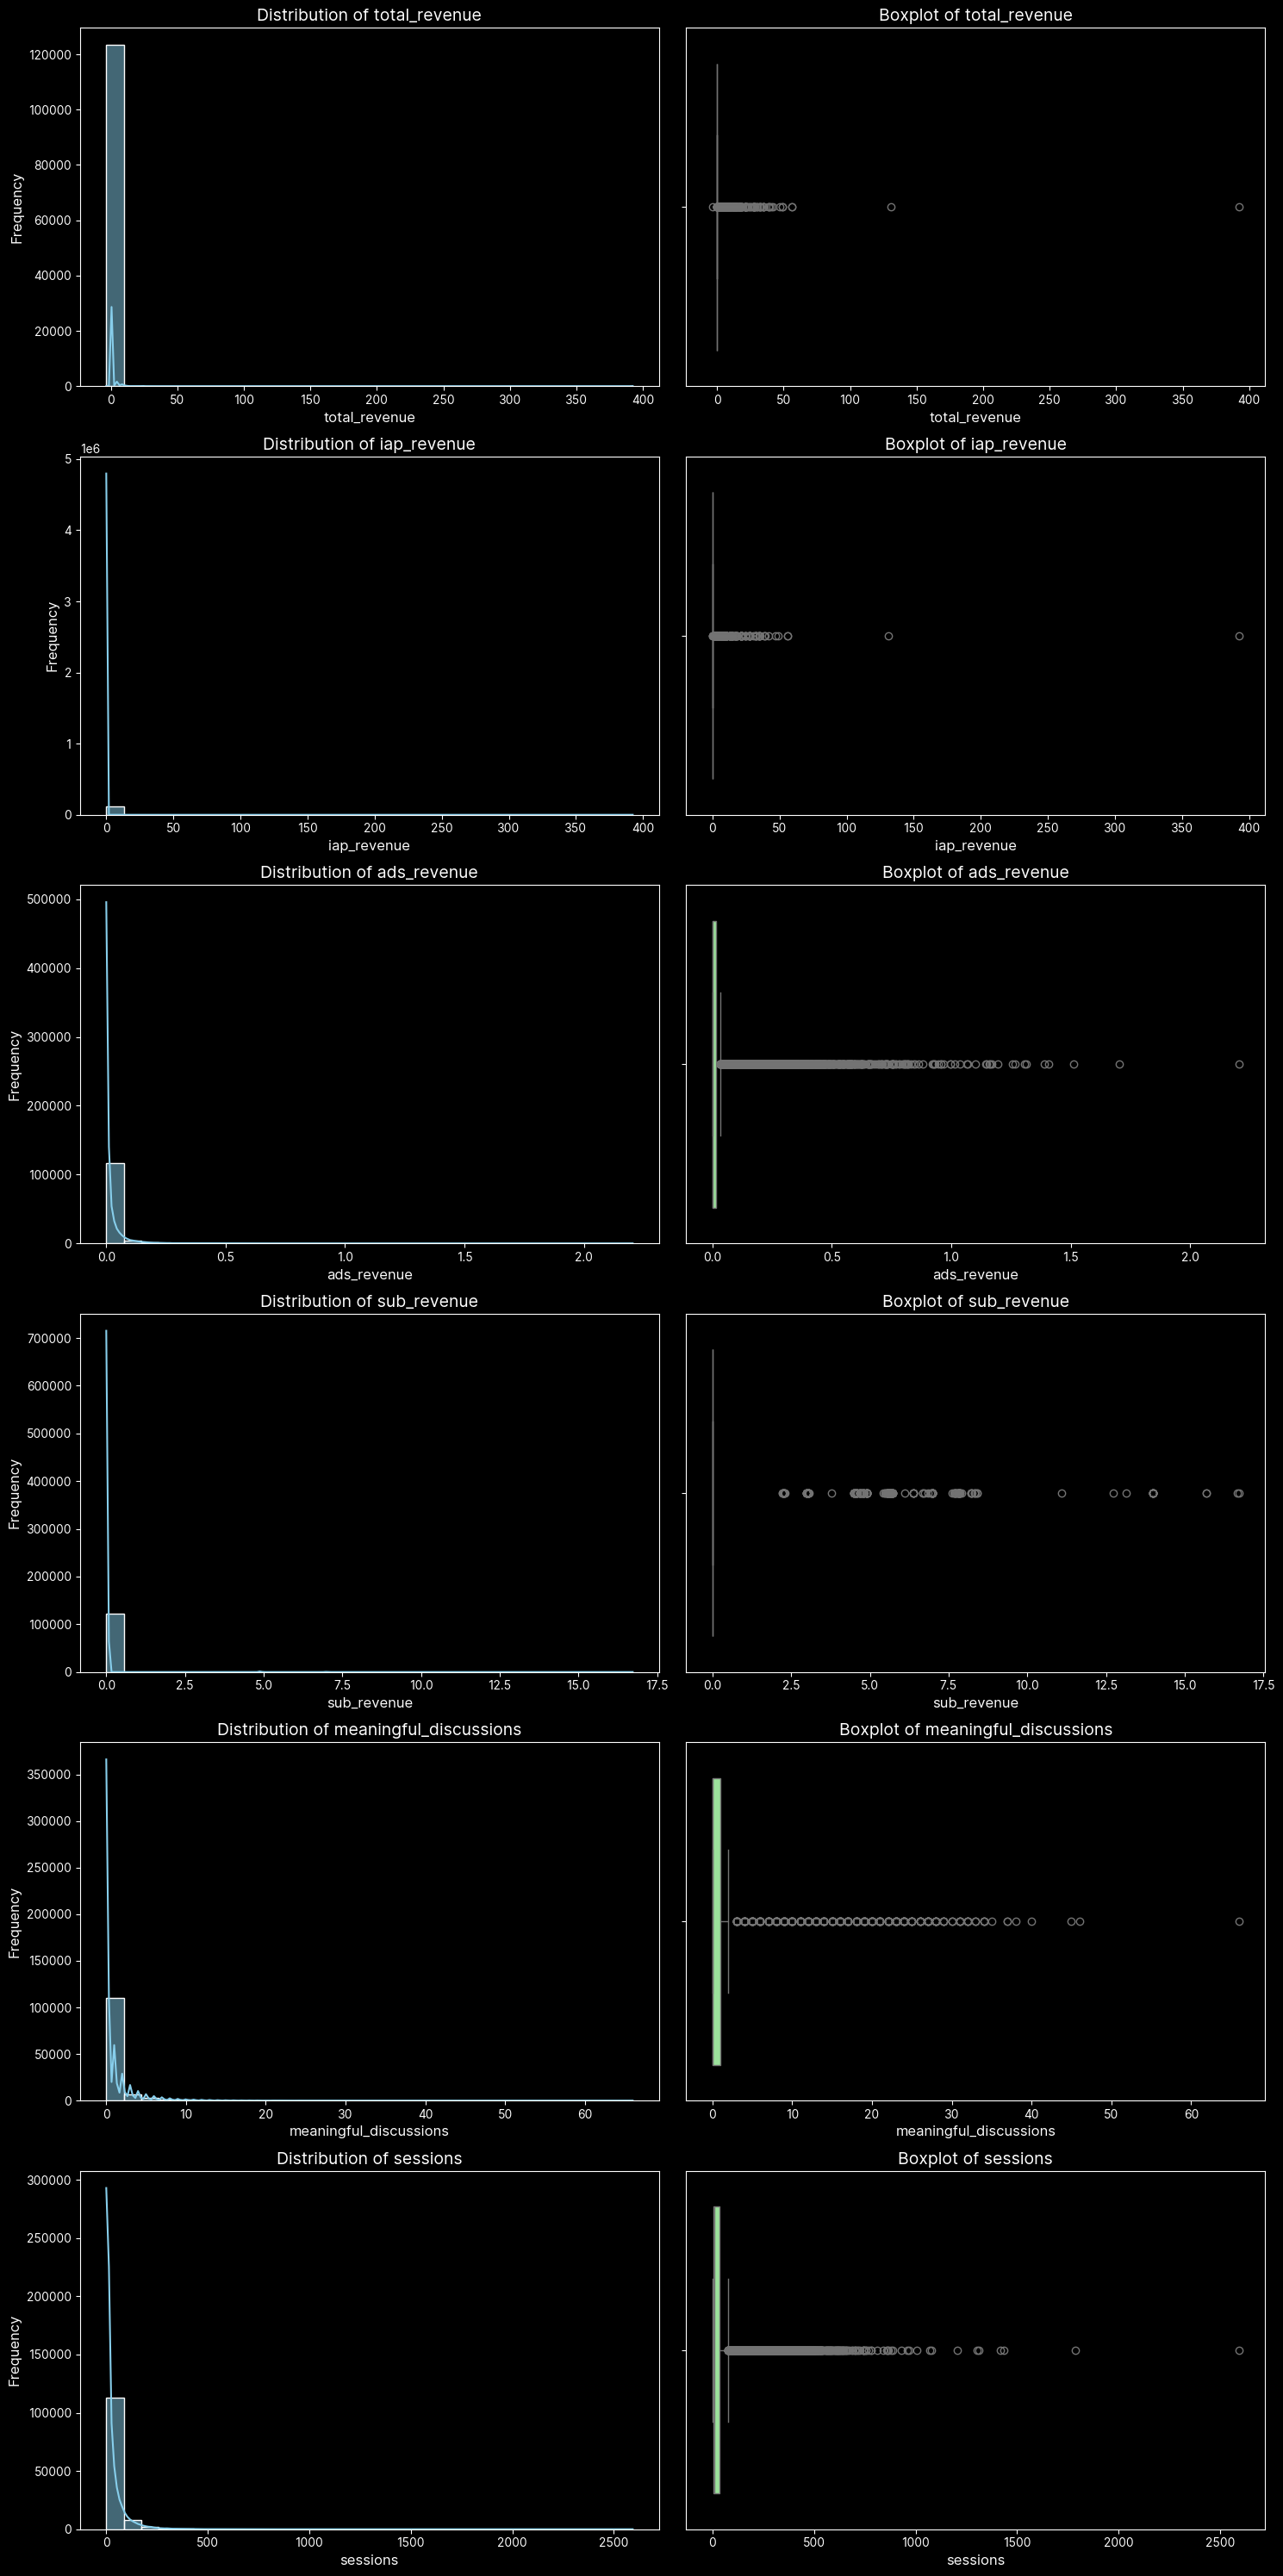

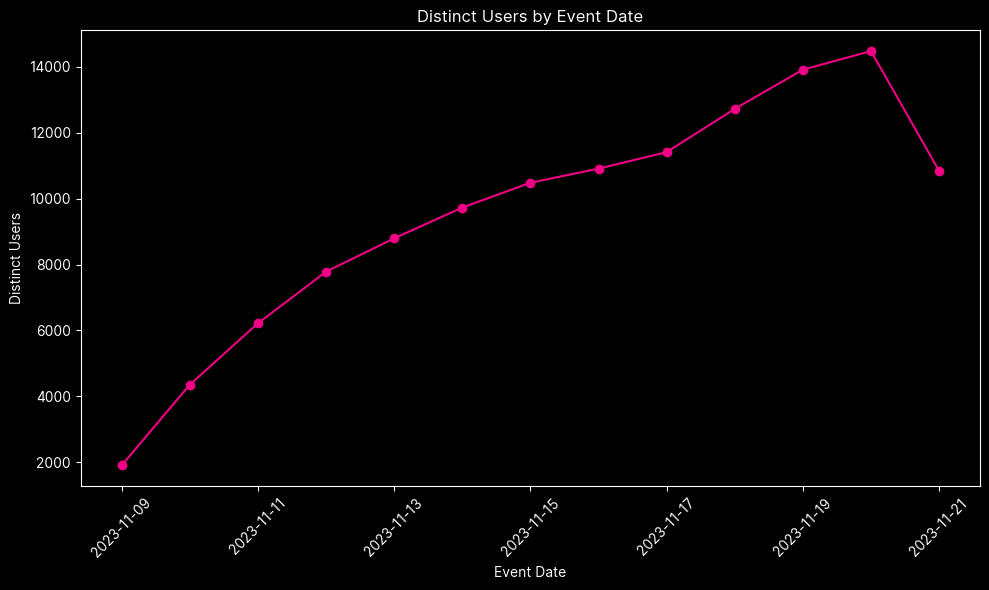

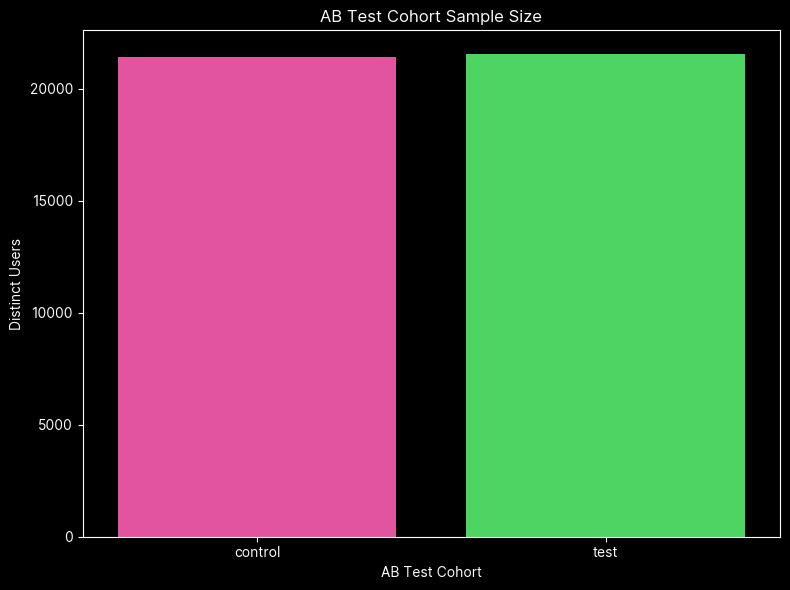

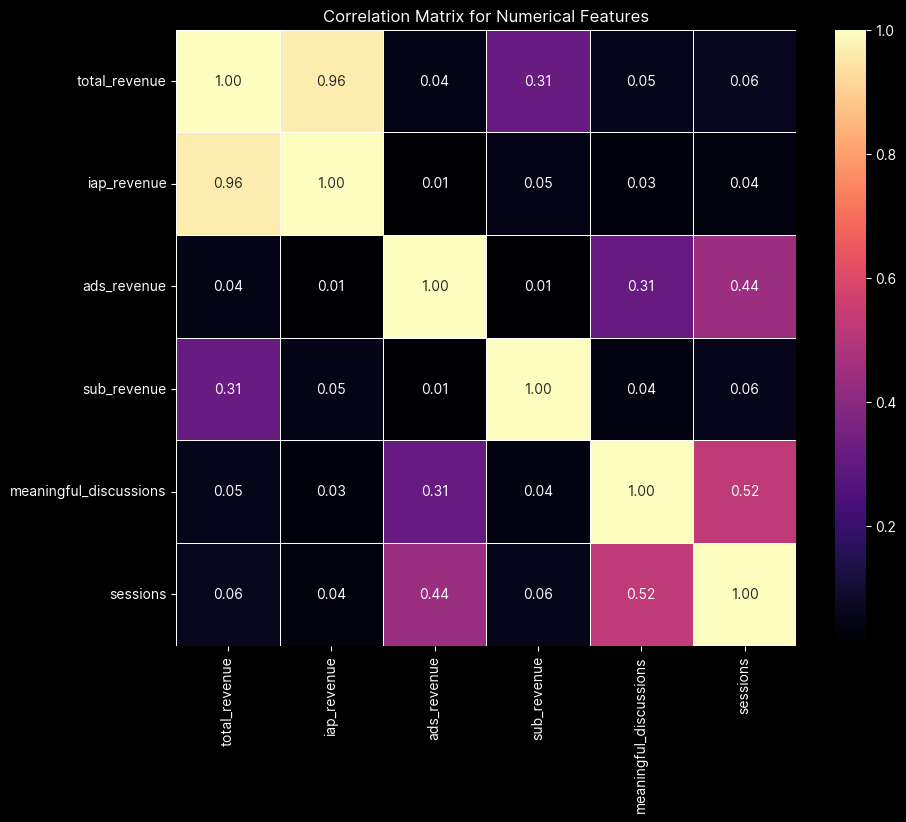


Unique Values in Columns:
keychain_udid             42966
event_date                   13
ab_test_cohort                2
total_revenue             70946
iap_revenue                 195
ads_revenue               70812
sub_revenue                 120
meaningful_discussions       42
sessions                    586
dtype: int64


In [63]:
num_col_eda(ab_data)

In [140]:
df = ab_data.copy()
df['event_date'] = pd.to_datetime(df['event_date'])
cohort_min_date = df.groupby('ab_test_cohort')['event_date'].min().reset_index()
cohort_min_date.columns = ['ab_test_cohort', 'd0']
df = df.merge(cohort_min_date, on='ab_test_cohort')
df['d3'] = df['d0'] + timedelta(days=3)
df['d6'] = df['d0'] + timedelta(days=6)
df['d12'] = df['d0'] + timedelta(days=12)

# Get distinct user counts per cohort at each time period
users_on_d0 = df[df['event_date'] == df['d0']].groupby(['ab_test_cohort'])['keychain_udid'].nunique().reset_index()
users_on_d0.columns = ['ab_test_cohort', 'distinct_users_d0']
users_on_d3 = df[df['event_date'] >= df['d3']].groupby(['ab_test_cohort'])['keychain_udid'].nunique().reset_index()
users_on_d3.columns = ['ab_test_cohort', 'distinct_users_d3']
users_on_d6 = df[df['event_date'] >= df['d6']].groupby(['ab_test_cohort'])['keychain_udid'].nunique().reset_index()
users_on_d6.columns = ['ab_test_cohort', 'distinct_users_d6']
users_on_d12 = df[df['event_date'] >= df['d12']].groupby(['ab_test_cohort'])['keychain_udid'].nunique().reset_index()
users_on_d12.columns = ['ab_test_cohort', 'distinct_users_d12']

# Get total # of session per cohort to be used as retention flags
sessions_on_d0 = df[df['event_date'] == df['d0']].groupby(['ab_test_cohort', 'keychain_udid'])['sessions'].sum().reset_index()
sessions_on_d3 = df[df['event_date'] >= df['d3']].groupby(['ab_test_cohort', 'keychain_udid'])['sessions'].sum().reset_index()
sessions_on_d6 = df[df['event_date'] >= df['d6']].groupby(['ab_test_cohort', 'keychain_udid'])['sessions'].sum().reset_index()
sessions_on_d12 = df[df['event_date'] >= df['d12']].groupby(['ab_test_cohort', 'keychain_udid'])['sessions'].sum().reset_index()
sessions_on_d6 = sessions_on_d6.rename(columns={'sessions': 'sessions_d6'})
sessions_on_d12 = sessions_on_d12.rename(columns={'sessions': 'sessions_d12'})

# Merge the session data into the retention data
retention_data = pd.merge(sessions_on_d0, sessions_on_d3, on=['ab_test_cohort', 'keychain_udid'], how='left', suffixes=('_d0', '_d3'))
retention_data = pd.merge(retention_data, sessions_on_d6, on=['ab_test_cohort', 'keychain_udid'], how='left')
retention_data = pd.merge(retention_data, sessions_on_d12, on=['ab_test_cohort', 'keychain_udid'], how='left')
retention_data = pd.merge(retention_data, users_on_d0, on='ab_test_cohort', how='left')
retention_data = pd.merge(retention_data, users_on_d3, on='ab_test_cohort', how='left')
retention_data = pd.merge(retention_data, users_on_d6, on='ab_test_cohort', how='left')
retention_data = pd.merge(retention_data, users_on_d12, on='ab_test_cohort', how='left')
columns_to_fill = ['sessions_d3', 'sessions_d6', 'sessions_d12']
retention_data[columns_to_fill] = retention_data[columns_to_fill].fillna(0)

# Retention flags based on whether sessions_dN > sessions_d0
retention_data['d3_retained'] = retention_data['sessions_d3'] > retention_data['sessions_d0']
retention_data['d6_retained'] = retention_data['sessions_d6'] > retention_data['sessions_d0']
retention_data['d12_retained'] = retention_data['sessions_d12'] > retention_data['sessions_d0']
cohort_retention_d3 = retention_data[retention_data['d3_retained']].groupby('ab_test_cohort')['keychain_udid'].nunique().reset_index()
cohort_retention_d3.columns = ['ab_test_cohort', 'distinct_retained_d3']
cohort_retention_d6 = retention_data[retention_data['d6_retained']].groupby('ab_test_cohort')['keychain_udid'].nunique().reset_index()
cohort_retention_d6.columns = ['ab_test_cohort', 'distinct_retained_d6']
cohort_retention_d12 = retention_data[retention_data['d12_retained']].groupby('ab_test_cohort')['keychain_udid'].nunique().reset_index()
cohort_retention_d12.columns = ['ab_test_cohort', 'distinct_retained_d12']

cohort_retention = cohort_retention_d3.merge(cohort_retention_d6, on='ab_test_cohort', how='left')
cohort_retention = cohort_retention.merge(cohort_retention_d12, on='ab_test_cohort', how='left')

distinct_users = retention_data.groupby('ab_test_cohort')['keychain_udid'].nunique().reset_index()
distinct_users.rename(columns={'keychain_udid': 'distinct_users'}, inplace=True)  # on d0
cohort_retention = cohort_retention.merge(distinct_users, on='ab_test_cohort', how='left')

cohort_retention['retention_rate_d3'] = (cohort_retention['distinct_retained_d3'] / cohort_retention['distinct_users']) * 100
cohort_retention['retention_rate_d6'] = (cohort_retention['distinct_retained_d6'] / cohort_retention['distinct_users']) * 100
cohort_retention['retention_rate_d12'] = (cohort_retention['distinct_retained_d12'] / cohort_retention['distinct_users']) * 100

cohort_retention['avg_retention_rate'] = cohort_retention[['retention_rate_d3', 'retention_rate_d6', 'retention_rate_d12']].mean(axis=1)
cohort_retention

,ab_test_cohort,distinct_retained_d3,distinct_retained_d6,distinct_retained_d12,distinct_users,retention_rate_d3,retention_rate_d6,retention_rate_d12,avg_retention_rate
0,control,271,194,17,956,28.34728,20.292887,1.778243,16.806137
1,test,247,170,18,950,26.00000,17.894737,1.894737,15.263158


In [65]:
retention_data.tail(10)

,ab_test_cohort,keychain_udid,sessions_d0,sessions_d3,sessions_d6,sessions_d12,distinct_users_d0,distinct_users_d3,distinct_users_d6,distinct_users_d12,d3_retained,d6_retained,d12_retained
1896,test,secure_FDE17882-654E-4205-81FD-BE3517ED6C62,33,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1897,test,secure_FE8A0B6D-9C20-454B-9CFC-78F31238175C,15,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1898,test,secure_FEE3313B-1A99-48B7-B4CA-C99784B925A4,30,2.0,1.0,0.0,950,19355,16157,5606,False,False,False
1899,test,secure_FF3EF268-295B-48D9-89E7-3D1746EE1D8D,108,1778.0,1549.0,321.0,950,19355,16157,5606,True,True,True
1900,test,secure_FF5F3104-87D6-4A49-AF7F-165F6618DAC9,32,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1901,test,secure_FFF9CD12-1DB1-4566-9F5D-3A38C121C956,27,4.0,0.0,0.0,950,19355,16157,5606,False,False,False
1902,test,secure_a86b0f6dfb073578,2,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1903,test,secure_bac412468bae4e5f,1,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1904,test,secure_ece959de7c10c9ce,1,0.0,0.0,0.0,950,19355,16157,5606,False,False,False
1905,test,secure_efa827b3f9576972,1,0.0,0.0,0.0,950,19355,16157,5606,False,False,False


In [144]:
# Stats testing main metric
retention_data['d3_retention_rate'] = retention_data['d3_retained'] / retention_data['distinct_users_d0']
retention_data['d6_retention_rate'] = retention_data['d6_retained'] / retention_data['distinct_users_d0']
retention_data['d12_retention_rate'] = retention_data['d12_retained'] / retention_data['distinct_users_d0']
retention_data['avg_retention_rate'] = retention_data[['d3_retention_rate', 'd6_retention_rate', 'd12_retention_rate']].mean(axis=1)

control_data = retention_data[retention_data['ab_test_cohort'] == 'control']
test_data = retention_data[retention_data['ab_test_cohort'] == 'test']

stat_mw, p_mw = mannwhitneyu(control_data['avg_retention_rate'], test_data['avg_retention_rate'])
stat_ks, p_ks = ks_2samp(control_data['avg_retention_rate'], test_data['avg_retention_rate'])
p_values_df = pd.DataFrame({
    'Metric': ['avg_retention_rate', 'avg_retention_rate'],
    'Test': ['Mann-Whitney U', 'Kolmogorov-Smirnov'],
    'P-value': [p_mw, p_ks]
})
print(f"Mann-Whitney U Test for Average Retention Rate: Statistic={stat_mw}, P-value={p_mw}")
print(f"Kolmogorov-Smirnov Test for Average Retention Rate: Statistic={stat_ks}, P-value={p_ks}")

alpha = 0.05
if p_mw < alpha:
    print("The difference in average retention rates between control and test groups is statistically significant (Mann-Whitney U Test).")
else:
    print("The difference in average retention rates between control and test groups is not statistically significant (Mann-Whitney U Test).")

if p_ks < alpha:
    print("The difference in average retention rates between control and test groups is statistically significant (Kolmogorov-Smirnov Test).")
else:
    print("The difference in average retention rates between control and test groups is not statistically significant (Kolmogorov-Smirnov Test).")

print(tabulate(p_values_df, headers='keys', tablefmt='grid'))

Mann-Whitney U Test for Average Retention Rate: Statistic=448812.5, P-value=0.5738597389163789
Kolmogorov-Smirnov Test for Average Retention Rate: Statistic=0.16116494164280995, P-value=2.7699406650939687e-11
The difference in average retention rates between control and test groups is not statistically significant (Mann-Whitney U Test).
The difference in average retention rates between control and test groups is statistically significant (Kolmogorov-Smirnov Test).
+----+--------------------+--------------------+-------------+
|    | Metric             | Test               |     P-value |
+====+====================+====================+=============+
|  0 | avg_retention_rate | Mann-Whitney U     | 0.57386     |
+----+--------------------+--------------------+-------------+
|  1 | avg_retention_rate | Kolmogorov-Smirnov | 2.76994e-11 |
+----+--------------------+--------------------+-------------+


In [109]:
styled_p_values = p_values_df.style.format(
    {'P-value': '{:.6e}'},
    subset=['P-value']
).applymap(
    lambda x: 'color: green' if x < 0.05 else 'color: red',
    subset=['P-value']
).set_properties(**{'text-align': 'center'})
styled_p_values

,Metric,Test,P-value
0,avg_retention_rate,Mann-Whitney U,5.738597e-01
1,avg_retention_rate,Kolmogorov-Smirnov,2.769941e-11


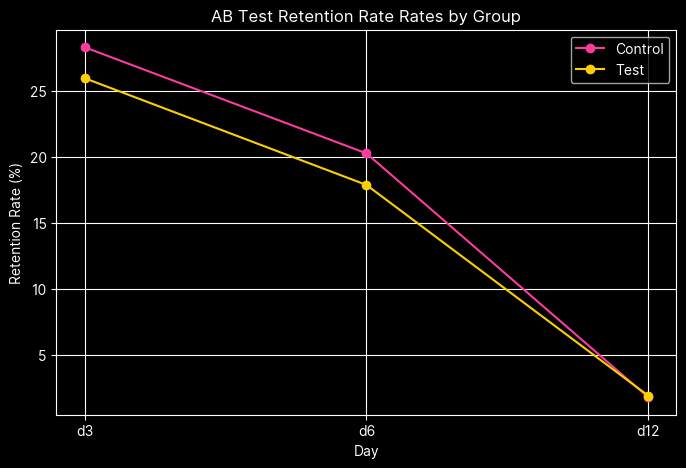

In [105]:
control_data = retention_data[retention_data['ab_test_cohort'] == 'control']
test_data = retention_data[retention_data['ab_test_cohort'] == 'test']

def calculate_retention_rate(df, day_col, distinct_users_col):
    retained_users = df[day_col].sum()
    distinct_users = df[distinct_users_col].iloc[0]
    return (retained_users / distinct_users) * 100

control_retention_d3 = calculate_retention_rate(control_data, 'd3_retained', 'distinct_users_d0')
control_retention_d6 = calculate_retention_rate(control_data, 'd6_retained', 'distinct_users_d0')
control_retention_d12 = calculate_retention_rate(control_data, 'd12_retained', 'distinct_users_d0')

test_retention_d3 = calculate_retention_rate(test_data, 'd3_retained', 'distinct_users_d0')
test_retention_d6 = calculate_retention_rate(test_data, 'd6_retained', 'distinct_users_d0')
test_retention_d12 = calculate_retention_rate(test_data, 'd12_retained', 'distinct_users_d0')

days = ['d3', 'd6', 'd12']
control_retention = [control_retention_d3, control_retention_d6, control_retention_d12]
test_retention = [test_retention_d3, test_retention_d6, test_retention_d12]

plt.figure(figsize=(8, 5))
plt.plot(days, control_retention, label='Control', marker='o', color=retention_colors[0])
plt.plot(days, test_retention, label='Test', marker='o', color=retention_colors[2])
plt.title('AB Test Retention Rate Rates by Group')
plt.xlabel('Day')
plt.ylabel('Retention Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
# Checking guardrail metrics
grouped = ab_data.groupby(['ab_test_cohort', 'keychain_udid']).agg(
    total_sessions=('sessions', 'sum'),
    total_meaningful_discussions=('meaningful_discussions', 'sum'),
    total_ads_revenue=('ads_revenue', 'sum'),
    total_iap_revenue=('iap_revenue', 'sum')
).reset_index()
cohort_summary = grouped.groupby('ab_test_cohort').agg(
    avg_sessions=('total_sessions', 'mean'),
    avg_meaningful_discussions=('total_meaningful_discussions', 'mean'),
    avg_ads_revenue=('total_ads_revenue', 'mean'),
    avg_iap_revenue=('total_iap_revenue', 'mean')
).reset_index()
print(tabulate(cohort_summary, headers='keys', tablefmt='grid'))

metrics = ['total_sessions', 'total_meaningful_discussions', 'total_ads_revenue', 'total_iap_revenue']
p_values_df = pd.DataFrame(columns=['Metric', 'Test', 'P-value'])

for metric in metrics:
    control_data = grouped[grouped['ab_test_cohort'] == 'control'][metric]
    test_data = grouped[grouped['ab_test_cohort'] == 'test'][metric]

    mann_stat, mann_p = mannwhitneyu(control_data, test_data)
    p_values_df = pd.concat([p_values_df, pd.DataFrame({'Metric': [metric], 'Test': ['Mann-Whitney U'], 'P-value': [mann_p]})], ignore_index=True)

    ks_stat, ks_p = ks_2samp(control_data, test_data)
    p_values_df = pd.concat([p_values_df, pd.DataFrame({'Metric': [metric], 'Test': ['Kolmogorov-Smirnov'], 'P-value': [ks_p]})], ignore_index=True)

    print(f"\n{metric} - Mann-Whitney U Test: Statistic={mann_stat}, P-value={mann_p}")
    print(f"{metric} - Kolmogorov-Smirnov Test: Statistic={ks_stat}, P-value={ks_p}")

print(tabulate(p_values_df, headers='keys', tablefmt='grid'))

+----+------------------+----------------+------------------------------+-------------------+-------------------+
|    | ab_test_cohort   |   avg_sessions |   avg_meaningful_discussions |   avg_ads_revenue |   avg_iap_revenue |
+====+==================+================+==============================+===================+===================+
|  0 | control          |        85.4004 |                      2.38012 |         0.0501545 |          0.114496 |
+----+------------------+----------------+------------------------------+-------------------+-------------------+
|  1 | test             |        87.364  |                      2.52755 |         0.0475228 |          0.105066 |
+----+------------------+----------------+------------------------------+-------------------+-------------------+

total_sessions - Mann-Whitney U Test: Statistic=225548486.0, P-value=5.049534003030871e-05
total_sessions - Kolmogorov-Smirnov Test: Statistic=0.02747390786135928, P-value=1.778176352981503e-07

total_

In [134]:
styled_p_values = p_values_df.style.format(
    {'P-value': '{:.6e}'},
    subset=['P-value']
).applymap(
    lambda x: 'color: green' if x < 0.05 else 'color: red',
    subset=['P-value']
).set_properties(**{'text-align': 'center'})
styled_p_values

,Metric,Test,P-value
0,total_sessions,Mann-Whitney U,5.049534e-05
1,total_sessions,Kolmogorov-Smirnov,1.778176e-07
2,total_meaningful_discussions,Mann-Whitney U,8.070877e-16
3,total_meaningful_discussions,Kolmogorov-Smirnov,4.838025e-17
4,total_ads_revenue,Mann-Whitney U,6.535955e-01
5,total_ads_revenue,Kolmogorov-Smirnov,3.793137e-01
6,total_iap_revenue,Mann-Whitney U,1.581850e-01
7,total_iap_revenue,Kolmogorov-Smirnov,1.000000e+00


No diff in revenue metrics (those which are assumed most related to user engagement) across groups